In [1]:
%pylab inline
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import time, sys
from IPython.display import clear_output
from scipy import stats
import scipy.stats
import scipy.optimize as opt
import scipy.io
# %load_ext jupyternotify
#Progress bar function
import time, sys

def update_progress(progress):
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

Populating the interactive namespace from numpy and matplotlib


In [2]:
#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f,p
# We have functions to convert proportion correct to z scores and vice versa
def ztop(z):
    p=0.5 * (1.0+scipy.special.erf(z/np.sqrt(2) ) )
    return p

def ptoz(p):
    if p==1:
        p=0.9999999
    elif p==0:
        p=0.0000001
    z=np.sqrt(2) * scipy.special.erfinv( 2*p-1.0)
    return z

def ptozM(p,M=4):
    if p==1:
        p=0.999999
    elif p==0:
        p=0.0001
    # from JEK Smith 1982. Checked to match tables of Hacker/Ratcliff
    K_M=0.86-0.085 * np.log(M-1)
    d=K_M*np.log( (M-1)*p/(1-p) )
    return d

# Function for getting bootstrapped zscores
def bootstrap_corr_to_z(df,num_boot=1000):
    z_scores=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        zVal=ptozM(resampled_df.mean())
        z_scores.append(zVal)
    return z_scores

# Function for getting bootstrapped prop values from 0/1 correct/incorrect response list
def bootstrap_corr_to_propCor(df,num_boot=1000):
    propCor=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        propCor.append(resampled_df.mean())
    return propCor

## Perumutation Test
def perm_test(c,t,num_perm,method='mean',z_score=True,*args):
    k=[]
    # Look if there are additional groups passed in
    if len(args)>1:
        t1=args[0]
        t2=agrs[1]
                
    if method=='mean':
        if z_score==True:
            diff=(ptozM(np.mean(c))-ptozM(np.mean(t)))
        else:
            diff=((np.mean(c))-(np.mean(t)))
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            if z_score==True:
                k.append((ptozM(np.mean(z[:int(len(c))])) - ptozM(np.mean(z[int(len(c)):]))))  
            else:
                k.append(((np.mean(z[:int(len(c))])) - (np.mean(z[int(len(c)):]))))  
        
    elif method=='ttest':
        # Compare between two sets of measures/data
        diff=stats.ttest_ind(c,t).statistic
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            tval=stats.ttest_ind(z[:int(len(c))],z[int(len(c)):])
            k.append(tval.statistic)
        
    elif method=='ftest':
        for arg in args:
            t2=arg
        if 't2' in locals():
            # Compare between more than two sets of measures/data
            diff,p_val=stats.f_oneway(c,t,t2).statistic
            z=np.concatenate([c,t,t2])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[:int(len(c))]
                g2=z[int(len(c)):(int(len(c))+int(len(t)))]
                g3=z[(int(len(c))+int(len(t))):]
                fval=stats.f_oneway(g1,g2,g3).statistic
                k.append(fval)
        else:
            # Compare between  two sets of measures/data
            diff,p_val=f_test(c,t)
            z=np.concatenate([c,t])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[0:int(len(c))]
                g2=z[int(len(c))::]
                fval,p_val=f_test(g1,g2)
                k.append(fval)
        
    elif method=='friedman':
        # compare between two sets of measures/data
        diff=stats.friedmanchisquare(c,t,t1,t2).statistic
        z=np.concatenate([c,t,t1,t2])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            len_df=len(c) # since lengths of groups are the same we use one of them
            g1=z[0:len_df]
            g2=z[len_df*1:len_df*2]
            g3=z[len_df*2:len_df*3]
            g4=z[len_df*3:len_df*4]
            friedman_test=stats.friedmanchisquare(g1,g2,g3,g4)
            k.append(friedman_test.statistic)
    if method=='mean':
        if diff>0: # when the original difference is positive
            p_value=len(np.where(k>=diff)[0])/num_perm
        elif diff<0: # when the original difference is negative
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)>0: # when the original difference is zero and distribution is positive
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)<0:# when the original difference is zero and distribution is negative
            p_value=len(np.where(k>=diff)[0])/num_perm
        else:# It wouldnt normally get here but just to prevent bugs
            p_value=1
    else: # all other test statistic
        if diff<np.mean(k):
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff>np.mean(k):
            p_value=len(np.where(k>=diff)[0])/num_perm
    
    # check if p_value exists, if not assign it a high value
    if 'p_value' not in locals():
        print('UnboundLocalError')
        p_value=1
    
            
    return {"diff":diff,"k":k,'p_val':p_value}

# GENERAL EQUATION ------------------------------------------------------------
#1. We use an exponential fit
#2. Or we use a weibull fit
def func(x, A, c, d):
    return A*np.exp(c*x) + d
# Wikipedia Weibull CDF https://en.wikipedia.org/wiki/Weibull_distribution
def func_weibull(x,lamb,k,lr):
    guess=0.25
    weibull_cdf=(1-np.exp(- (x/lamb)**k) )
    yval=guess+(1.0-guess-lr)*weibull_cdf
    return yval

In [ ]:
if sys.platform=='win32':
#     data_directory='Z:\TSLO_Experiment\VoluntaryMicrosaccade\Experiment2ObliqueMicrosaccadeWNeutral'
    data_directory='C:\TSLOBackup\Experiment3RadialTangential'
elif sys.platform=='linux':
    data_directory='/home/coateslab/LabData/TSLO_Experiment/VoluntaryMicrosaccade/Experiment1AllFlankers/'
filedir_list=[]
for root,dirs,file in os.walk(data_directory):
    if "Videos" in root and "Processed" not in root and "Pilot" not in root and "Training" not in root:
        filedir_list.append(root)

behav_compile=True
if behav_compile==True:
    # we get the path for the inidividual behavioral data files
    if sys.platform=='win32':
        behavdata_dir='C:\TSLOBackup\Experiment3RadialTangential'
    elif sys.platform=='linux':
        behavdata_dir='/home/coateslab/LabData/TSLO_Experiment/VoluntaryMicrosaccade/Experiment1AllFlankers/'
    behavdir_list=[]
    for root,dirs,file in os.walk(behavdata_dir):
        if "Behav"in root and "Pilot" not in root and "Training" not in root:
            behavdir_list.append(root)
        
#Saccade data compilation
#% time
#This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
#In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedMicroSacc=[]
microSaccData=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
            try:
                # First we load the mat file into jupyter
                mat=scipy.io.loadmat(os.path.join(foldername,filename))
                # we get the foldername from the filepath
    #             folderdate=foldername.replace('/mnt/hd/ao/vids/','')
                # initially we create empty pandas dataframes
                tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                            ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
                # we determine the size of the saccade array
                tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                        ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                saccArraySize=mat['params']['saccades'][0,0]['duration'].size # for now use one of the fields of the struct array
                durationList=[]
                onsetIdxList=[]
                offsetIdxList=[]
                onsetTimeList=[]
                offsetTimeList=[]
                xAmpList=[]
                yAmpList=[]
                VectorAmpList=[]
                DirectionList=[]
                peakVelList=[]
                maxVelList=[]
                for itemIdx in range(saccArraySize): #here we would want to unapack each item from the struct and append it to a list 
                    duration=(mat['params']['saccades'][0,0]['duration'][itemIdx].flatten().item().item())
                    onsetIdx=(mat['params']['saccades'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                    offsetIdx=(mat['params']['saccades'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                    onsetTime=((mat['params']['saccades'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                    offsetTime=(mat['params']['saccades'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                    xAmp=(mat['params']['saccades'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                    yAmp=(mat['params']['saccades'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                    VectorAmp=(mat['params']['saccades'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                    Direction=(mat['params']['saccades'][0,0]['direction'][itemIdx].flatten().item().item())
                    peakVel=(mat['params']['saccades'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                    maxVel=(mat['params']['saccades'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                    tempSaccData=tempSaccData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                                'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                                ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
                # We finally add file details to the data structure which can later be used to 
                # query into the dataframe
                tempSaccData['filename']=filename
                trialCode='%s'%(filename[0:filename.find('_Video')])
                if "_2.5_" in trialCode:
                    trialCode=trialCode.replace("_2.5_","_2.50_")
                tempSaccData['code']=trialCode
                tempSaccData['subj_id']=subj_id
                if 'NoMicrosaccade' in filename:
                    tempSaccData['microsaccade_cond']='NoMicrosaccade'
                else:
                    tempSaccData['microsaccade_cond']='Microsaccade'
    #             tempSaccData['foldername']=folderdate
    #             tempSaccData['code']='%s_%s'%(folderdate,filename[0:filename.find('_Eye')])
                #The temporary data is then appended to the bigger data structure 
                microSaccData.append(tempSaccData)
            except:
               failedMicroSacc.append(os.path.join(foldername,filename))
# create_dataframe=True
microSaccData=pd.concat(microSaccData)
# we then remove the saccade data with NaNs
microSaccFiltered=microSaccData[microSaccData['Direction'].notnull()]

# Drift data compilation
# % time
# This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
# In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedDrifts=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
            try:
                # First we load the mat file into jupyter
                mat=scipy.io.loadmat(os.path.join(foldername,filename))
                # we get the foldername from the filepath
    #             folderdate=foldername.replace('/mnt/hd/ao/rotVids/','')
                # initially we create empty pandas dataframes
                tempDriftData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
                # 1. form saccade dataset for the file
                # we determine the size of the saccade array
                tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                        ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                driftArraySize=mat['params']['drifts'][0,0]['duration'].size # for now use one of the fields of the struct array
                durationList=[]
                onsetIdxList=[]
                offsetIdxList=[]
                onsetTimeList=[]
                offsetTimeList=[]
                xAmpList=[]
                yAmpList=[]
                VectorAmpList=[]
                DirectionList=[]
                peakVelList=[]
                maxVelList=[]
                for itemIdx in range(driftArraySize): #here we would want to unapack each item from the struct and append it to a list 
                    duration=(mat['params']['drifts'][0,0]['duration'][itemIdx].flatten().item().item())
                    onsetIdx=(mat['params']['drifts'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                    offsetIdx=(mat['params']['drifts'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                    onsetTime=((mat['params']['drifts'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                    offsetTime=(mat['params']['drifts'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                    xAmp=(mat['params']['drifts'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                    yAmp=(mat['params']['drifts'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                    VectorAmp=(mat['params']['drifts'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                    Direction=(mat['params']['drifts'][0,0]['direction'][itemIdx].flatten().item().item())
                    peakVel=(mat['params']['drifts'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                    maxVel=(mat['params']['drifts'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                    tempDriftData=tempDriftData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                                'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                                ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
                # We finally add file details to the data structure which can later be used to 
                # query into the dataframe
                tempDriftData['filename']=filename
                trialCode='%s'%(filename[0:filename.find('_Video')])
                if "_2.5_" in trialCode:
                    trialCode=trialCode.replace("_2.5_","_2.50_")
                tempSaccData['code']=trialCode
                tempDriftData['subj_id']=subj_id
                if 'NoMicrosaccade' in filename:
                    tempDriftData['microsaccade_cond']='NoMicrosaccade'
                else:
                    tempDriftData['microsaccade_cond']='Microsaccade'
    #             tempDriftData['foldername']=folderdate
    #             tempDriftData['code']='%s_%s'%(folderdate,filename[0:filename.find('_Eye')])

                #The temporary data is then appended to the bigger data structure 
                driftData.append(tempDriftData)
            except:
                failedMicroSacc.append(os.path.join(foldername,filename))
#     create_dataframe=False
driftData=pd.concat(driftData)
# we then remove the saccade data with NaNs
driftDataFiltered=driftData[driftData['Direction'].notnull()]
  

if behav_compile==True:
    # Behav Data compilation
    behavdir_listles=[]
    behavData=[]
    questData=[]

    num_elements=len(behavdir_list)
    for foldername in behavdir_list:
        # we find subject ID
        subj_id=foldername[foldername.find('S0'):foldername.find('S0')+3]
        filelist=os.listdir(foldername)
        for filename in filelist:
            try:
                if 'Crowding' in filename and 'CrowdingQuest' not in filename and 'CrowdingThresh' not in filename:
                    # First we load the mat file into jupyter
                    tempBehav=pd.read_csv(os.path.join(foldername,filename))
                    tempBehav['filename']=filename
                    if "NoMicrosaccade" not in filename:
                        trialCode='%s_Microsaccade'%(filename[0:filename.find('_Crowding')])
                    else:
                        trialCode='%s'%(filename[0:filename.find('_Crowding')])
                    tempBehav['code']=trialCode
                    tempBehav['subj_id']=subj_id
                    if 'NoMicrosaccade' in filename and '_valid' in filename:
                        tempBehav['microsaccade_cond']='NoMicrosaccade_valid'
                    elif 'NoMicrosaccade' in filename and '_invalid' in filename:
                        tempBehav['microsaccade_cond']='NoMicrosaccade_invalid'
                    elif 'NoMicrosaccade' not in filename and '_valid' in filename:
                        tempBehav['microsaccade_cond']='Microsaccade_valid'
                    elif 'NoMicrosaccade' not in filename and '_invalid' in filename:
                        tempBehav['microsaccade_cond']='Microsaccade_invalid'
                    #The temporary data is then appended to the bigger data structure 
                    behavData.append(tempBehav)
                elif "CrowdingThresh" in filename:
                    #We again load data into jupyter
                    tempData=pd.read_csv(os.path.join(foldername,filename))
                    tempData['subj_id']=subj_id
                    # ///rly we build the dataframe
                    questData.append(tempData)
            except:
                print(filename)
    if len(questData)!=0:
        questData=pd.concat(questData)
    behavData=pd.concat(behavData)
    
    
# Marker data compilation
failedFiles=[]
markerData=[]
markerFixNeeded=True
# while create_dataframe==True:
counter=0
num_elements=len(filedir_list)
for foldername in filedir_list:
#     update_progress(counter/num_elements)
    counter+=1
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'marker' in filename and 'markerData' not in filename:
            # First we load the mat file into jupyter
            tempData=pd.read_csv(os.path.join(foldername,filename),names=['frameIdx','stripIdx'])
            tempData['stimulusOnsetTime']=(tempData['frameIdx']*(1000/30)/1000)+(tempData['stripIdx']*(1000/16000)/1000)
            if markerFixNeeded==True:
                if len(tempData)!=2: # Cases where marker is missing we get values from behav data
                    if "NoMicrosaccade" in filename:
                        trialCode='%s'%(filename[0:filename.find('_Video')])
                    else:
                        trialCode='%s'%(filename[0:filename.find('_Microsaccade')])
                    # Get this from the marker file, since the first marker would correspond to the cue onset. 
                    # The second missing one would correspond to the target onset
                    if len(tempData)>0:
                        cueOnsetTime=tempData['stimulusOnsetTime'].iloc[0]
                        # We get the behavioral data from the trial
                        behavDataTrial=behavData.query("code==@trialCode")
                        if len(behavDataTrial)>0: # valid ones
                            # We get this from behavioral data
                            cueDuration=behavDataTrial['cueDuration'].iloc[0]
                            # Using the two we figure out when the target happened
                            targetOnsetTime=cueOnsetTime+cueDuration
                            # We create a df with dummy strip values & calculation target onset time
                            markerFix=pd.DataFrame([[np.nan,np.nan,targetOnsetTime]],columns=['frameIdx','stripIdx','stimulusOnsetTime'])
                            # We finally append this to existing marker data
                            tempData=tempData.append(markerFix)


            tempData['filename']=filename
            tempData['code']='%s'%(filename[0:filename.find('_Video')])

            tempData['subj_id']=subj_id
            if 'NoMicrosaccade' in filename:
                tempData['microsaccade_cond']='NoMicrosaccade'
            else:
                tempData['microsaccade_cond']='Microsaccade'
            #The temporary data is then appended to the bigger data structure 
            markerData.append(tempData)
            
markerData=pd.concat(markerData)

## Behavioral Data: Quick Sample

In [ ]:
foldername='C:\\TSLOBackup\\RadialTangentialPilot\\WorseGlasses\\S02\\Videos\\new'
os.chdir(foldername)
for afile in os.listdir(foldername):
    if "_S1_" in afile:
        newFilename=afile.replace("_S1_","_S2_")
        os.rename(afile,newFilename)

In [ ]:
# we get the path for the inidividual behavioral data files
foldername='C:\\projects\\tslo_core\External_display\\Results'
behavdir_list=[]

# Behav Data compilation
behavData_sample=[]
questData=[]

num_elements=len(behavdir_list)

# we find subject ID
subj_id=foldername[foldername.find('S0'):foldername.find('S0')+3]
filelist=os.listdir(foldername)
for filename in filelist:
    try:
        if 'Crowding' in filename and 'CrowdingQuest' not in filename and 'CrowdingThresh' not in filename:
            # First we load the mat file into jupyter
            tempBehav=pd.read_csv(os.path.join(foldername,filename))
            tempBehav['filename']=filename
            if "NoMicrosaccade" not in filename:
                trialCode='%s_Microsaccade'%(filename[0:filename.find('_Crowding')])
            else:
                trialCode='%s'%(filename[0:filename.find('_Crowding')])
            tempBehav['code']=trialCode
            tempBehav['subj_id']=subj_id
            if 'NoMicrosaccade' in filename and '_valid' in filename:
                tempBehav['microsaccade_cond']='NoMicrosaccade_valid'
            elif 'NoMicrosaccade' in filename and '_invalid' in filename:
                tempBehav['microsaccade_cond']='NoMicrosaccade_invalid'
            elif 'NoMicrosaccade' not in filename and '_valid' in filename:
                tempBehav['microsaccade_cond']='Microsaccade_valid'
            elif 'NoMicrosaccade' not in filename and '_invalid' in filename:
                tempBehav['microsaccade_cond']='Microsaccade_invalid'
            #The temporary data is then appended to the bigger data structure 
            behavData_sample.append(tempBehav)
        elif "CrowdingThresh" in filename:
            #We again load data into jupyter
            tempData=pd.read_csv(os.path.join(foldername,filename))
            tempData['subj_id']=subj_id
            # ///rly we build the dataframe
            questData.append(tempData)
    except:
        print(filename)
if len(questData)!=0:
    questData=pd.concat(questData)
behavData_sample=pd.concat(behavData_sample)

sns.pointplot(data=behavData_sample,x='spacing',y='corr',order=['tangential','radial'],dodge=0.1)
plt.ylim(0,1)

## Relative Saccade DataFrame

In [ ]:
#Compiles microsaccades that occurs following the last stimulus onset
import warnings
warnings.filterwarnings('ignore')
# Given that there is a latency beetween teensy trigger and display update
# we add a fudge factor
teensy_fudgeFactor=0.018 #ms
# We add this to the marker time stamps
markerData['stimulusOnsetTime']=markerData['stimulusOnsetTime']+teensy_fudgeFactor

codeList=microSaccFiltered['code'].unique()
relSaccData=[]
relStimTime=[]
relSacc=[]
for acode in codeList:
    try:
        lastStimTime=markerData.query("code==@acode")['stimulusOnsetTime'].iloc[1]
        # get only saccades that occur after final stimulus
        # We try to get only the first microsaccade that occurs after stimulus onset
        tempSacc=microSaccFiltered.query("code==@acode & @lastStimTime<onsetTime<(@lastStimTime+0.600)")
        if len(tempSacc)>0:
            sacc=tempSacc['onsetTime'].iloc[0]
            relSaccTime=sacc-lastStimTime
            relSacc.append(relSaccTime)
        tempSacc['lastStimTime']=lastStimTime
        tempSacc['relOnsetTime']=tempSacc['onsetTime']-lastStimTime
        # get stimulus time relative to saccade onset
        if len(tempSacc)>0:
            saccOnsetTime=tempSacc['onsetTime'].iloc[0]
            relStimOnsetTime=lastStimTime-saccOnsetTime
            relStimTime.append(relStimOnsetTime)
            tempSacc['relStimTime']=relStimOnsetTime
        else:
            tempSacc['relStimTime']=np.nan
        # we add only the first microsaccade to the saccade array
        relSaccData.append(tempSacc.head(1))
    except (IndexError,NameError) as e:
        pass
relSaccData=pd.concat(relSaccData)
# 1. Only use saccade events with Duration>15 ms and Duration<80ms 
#relSaccData=relSaccData.query("0.015<Duration<0.080")

In [3]:
# Here we import existing DFs
os.chdir("D:\KSP\Study\Houston\Projects\TSLOExperiments\TSLOData\CrowdingVoluntaryMicrosaccade\Experiment3_radialTangential\Data")
microSaccFiltered=pd.read_csv("D:\KSP\Study\Houston\Projects\TSLOExperiments\TSLOData\CrowdingVoluntaryMicrosaccade\Experiment3_radialTangential\Data\SaccData.csv")
driftDataFiltered=pd.read_csv("D:\KSP\Study\Houston\Projects\TSLOExperiments\TSLOData\CrowdingVoluntaryMicrosaccade\Experiment3_radialTangential\Data\DriftData.csv")
markerData=pd.read_csv("D:\KSP\Study\Houston\Projects\TSLOExperiments\TSLOData\CrowdingVoluntaryMicrosaccade\Experiment3_radialTangential\Data\markerData.csv")
relSaccData=pd.read_csv("D:\\KSP\\Study\\Houston\\Projects\\TSLOExperiments\\TSLOData\\CrowdingVoluntaryMicrosaccade\\Experiment3_radialTangential\\Data\\relSaccData.csv")
behavData=pd.read_csv("D:\KSP\Study\Houston\Projects\TSLOExperiments\TSLOData\CrowdingVoluntaryMicrosaccade\Experiment3_radialTangential\Data\BehavData.csv")
relSaccData_postSaccade=pd.read_csv("D:\\KSP\\Study\\Houston\\Projects\\TSLOExperiments\\TSLOData\\CrowdingVoluntaryMicrosaccade\\Experiment3_radialTangential\\Data\\relSaccDataPostSaccOnset.csv")
# We also import behav data from control condition
behavDataControl=pd.read_csv("D:\\KSP\Study\\Houston\\Projects\\TSLOExperiments\\TSLOData\\CrowdingVoluntaryMicrosaccade\\Experiment5_controlCondition\\behavDataControlCondition.csv")

In [4]:
#A temoporal cut-off is set & trials with micrsaccades in that time window are grouped as trials with microsaccades & the rest as trials without microsaccades
# We set the value that would be used to distinguish between saccade & no saccade trials
# no microsaccade trials
behavDataNoMicrosaccadeWsaccades=list(behavData.query("microsaccade_cond=='NoMicrosaccade_valid' or microsaccade_cond=='NoMicrosaccade_invalid'")['code'])
NoMicroSaccadeFailedTrial=relSaccData.query("code==@behavDataNoMicrosaccadeWsaccades and relStimTime>-0.300")['code']
behavDataNoMicrosaccade=behavData[behavData.code.isin(behavDataNoMicrosaccadeWsaccades)]
# saccade Trials
behavDataSaccadeList=list(behavData.query("microsaccade_cond=='Microsaccade_valid' or microsaccade_cond=='Microsaccade_invalid'")['code'])
saccadeTrials=relSaccData.query("code==@behavDataSaccadeList")
saccadeData=pd.merge(saccadeTrials,behavData,left_on='code',right_on='code',copy=False)
# Also create a separate DF for trials with stimuli occuring post saccade onset
behavDataSaccadeList=list(behavData.query("microsaccade_cond=='Microsaccade_valid' or microsaccade_cond=='Microsaccade_invalid'")['code'])
saccadeTrials_postSaccade=relSaccData_postSaccade.query("code==@behavDataSaccadeList")
saccadeDataWpostSaccade=pd.merge(saccadeTrials_postSaccade,behavData,left_on='code',right_on='code',copy=False)
# The saccade directions range from -180 to +180 and uses the atan2d function in matlab. So to retrieve values that range between 0 and 360 we add 360 for values that\n",
# are below 0
saccadeData['DirectionPolar']=0
for i in range(len(saccadeData)):
    if saccadeData['Direction'].iloc[i]<0:
        saccadeData['DirectionPolar'].iloc[i]=saccadeData['Direction'].iloc[i]+360
    else:
        saccadeData['DirectionPolar'].iloc[i]=saccadeData['Direction'].iloc[i]
# Do the same for other saccade DF
saccadeDataWpostSaccade['DirectionPolar']=0
for i in range(len(saccadeDataWpostSaccade)):
    if saccadeDataWpostSaccade['Direction'].iloc[i]<0:
        saccadeDataWpostSaccade['DirectionPolar'].iloc[i]=saccadeDataWpostSaccade['Direction'].iloc[i]+360
    else:
        saccadeDataWpostSaccade['DirectionPolar'].iloc[i]=saccadeDataWpostSaccade['Direction'].iloc[i]

c:\Users\krish\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Filter relevant microsaccades

In [5]:
# Filter saccade data based on relative stimulus onset time
sacc200msOnsetDF=saccadeData.query("relStimTime>-0.200 and 180<DirectionPolar<270")
# Apply the same filter for trials with stimuli presented following saccade onset
sacc600msOnsetDFWpostSaccade=saccadeDataWpostSaccade.query("relStimTime>-0.600 and 180<DirectionPolar<270 & 0.015<Duration<0.080")

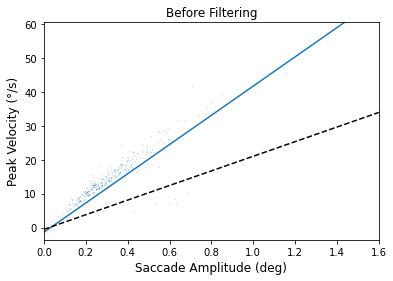

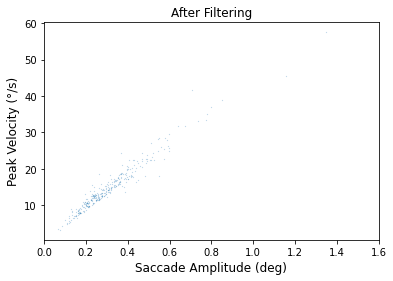

In [6]:
# We filter saccade events from every trial
# 1. Only use saccade events with Duration>15 ms and Duration<80ms 
# 2. We also filter data to use samples that fall on the main sequence/remove outliers(artifacts from saccade detectio method)
sacc200msOnsetDF=sacc200msOnsetDF.query("0.015<Duration<0.080")

#Only use samples that fall along the main sequence plot and show linear relationship
x=(sacc200msOnsetDF.VectorAmp.values)
y=(sacc200msOnsetDF.peakVel.values)
xMax=1.6
# First get edges from histogram
num_bins=150
counts, yedges, xedges = np.histogram2d(y, x, bins=num_bins)
# counts, yedges, xedges = np.histogram2d(y, x, bins=num_bins,range=[[0,np.max(y)], [0,np.max(x)]])
#Hough transform
from skimage.transform import hough_line, hough_line_peaks
h, theta, d = hough_line(counts)
#Plot output
plt.figure()
plt.scatter(x, y,s=.01)
plt.xlim(0,xMax)
#line x & y values
x_vals=[]
y_vals=[]
slope_vals=[]
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (y0,x0) = dist * np.array([np.cos(angle), np.sin(angle)])

    orig_slope=np.tan(angle + np.pi/2)
    new_x0=x0/num_bins*(xedges[-2])
    new_y0=y0/num_bins*(yedges[-2])
    new_slope=orig_slope*(np.max(yedges)/np.max(xedges))
    plt.axline((new_x0, new_y0), slope=new_slope)
    x_vals.append(new_x0)
    y_vals.append(new_y0)
    slope_vals.append(new_slope)
# We get the mid-point
x_mid=np.sum(x_vals)/2
y_mid=np.sum(y_vals)/2
slope_mid=np.sum(slope_vals)/2
# we draw line in between
plt.axline((x_mid,y_mid),slope=slope_mid,color='k',ls='--')

plt.xlabel('Saccade Amplitude (deg)',size=12)
plt.ylabel('Peak Velocity (°/s)',size=12)
plt.title('Before Filtering')

plt.figure()
below_line=y>(slope_mid*x)
x_filtered=x[below_line]
y_filtered=y[below_line]
plt.scatter(x_filtered,y_filtered,s=.01)
# Also get rejected data which we can also use to plot
below_line=y<(slope_mid*x)
x_reject=x[below_line]
y_reject=y[below_line]
plt.xlabel('Saccade Amplitude (deg)',size=12)
plt.ylabel('Peak Velocity (°/s)',size=12)
plt.title("After Filtering")
plt.xlim(0,xMax)
# #Finally we tweak the saccade dataframe to use the filtered values
sacc200msOnsetDF=sacc200msOnsetDF.loc[sacc200msOnsetDF['VectorAmp'].isin(x_filtered)]
sacc_rejected=sacc200msOnsetDF.loc[sacc200msOnsetDF['VectorAmp'].isin(x_reject)]

## Microsaccade characteristics

(-0.2, 0.0)

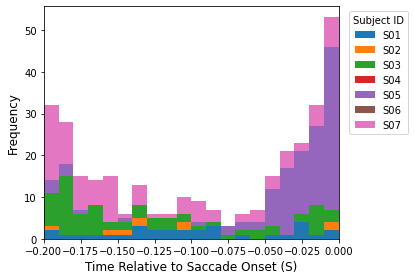

In [7]:
df=sacc200msOnsetDF
plt.hist([df.query("subj_id_x=='S01'")['relStimTime'],df.query("subj_id_x=='S02'")['relStimTime'],df.query("subj_id_x=='S03'")['relStimTime'],df.query("subj_id_x=='S04'")['relStimTime'],df.query("subj_id_x=='S05'")['relStimTime'],df.query("subj_id_x=='S06'")['relStimTime'],df.query("subj_id_x=='S07'")['relStimTime']],stacked=True,bins=20,label=['S01','S02','S03','S04','S05','S06','S07'])
plt.legend(title='Subject ID',bbox_to_anchor=(1.25,1))
plt.xlabel("Time Relative to Saccade Onset (S)",size=12)
plt.ylabel("Frequency",size=12)
plt.tight_layout()
plt.xlim(-0.2,0)
#plt.savefig("..\Plots\stimuliOnsetRelativetoSaccade.svg",dpi=1200,bbox_tight='inches')

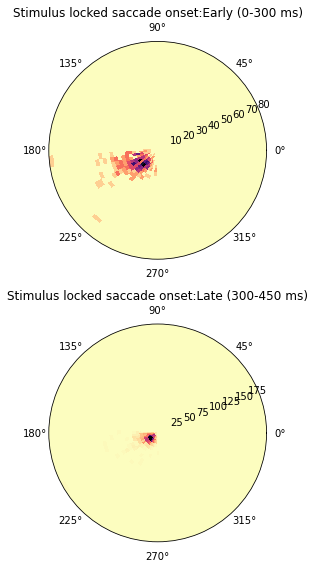

In [12]:
fig,axs=plt.subplots(2,1,subplot_kw={'projection':'polar'},figsize=(8,8))
counter=0
stimLocs=['lowerLeft']
astim=stimLocs[counter]
heatmap=True
for row in axs:
    # two input arrays
    if counter==0:
        data=sacc200msOnsetDF.query("relStimTime>-0.200")
        titleMsg='Early (0-300 ms)'
    else:
        data=sacc600msOnsetDFWpostSaccade
        titleMsg='Late (300-450 ms)'

    arr=np.radians(data['DirectionPolar'])
    radius=data['VectorAmp']*60

    if heatmap==True:
        # define binning
        rbins = np.linspace(0,radius.max(), 30)
        abins = np.linspace(0,2*np.pi, 60)
        #calculate histogram
        hist, _, _ = np.histogram2d(arr, radius, bins=(abins, rbins))
        A, R = np.meshgrid(abins, rbins)
        pc = row.pcolormesh(A, R, hist.T, cmap="magma_r")
        #Column title
        row.set_title("Stimulus locked saccade onset:%s"%(titleMsg))
        fig.tight_layout()
    else:
        N = 45
        bottom = 2

        # create theta for 24 hours
        theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

        # make the histogram that bined on 24 hour
        radii, tick = np.histogram(arr, bins = N)

        # width of each bin on the plot
        width = (2*np.pi) / N

        bars = row.bar(theta, radii, width=width, bottom=bottom)

        # set the lable go clockwise and start from the top
        row.set_theta_zero_location("E")
        # counter-clockwise
        row.set_theta_direction(1)

        # set the label
        ticks = ['0', '45°', '90°', '135°', '180°', '225°', '270°', '315°']
        row.set_xticklabels(ticks)
        #Column title
        row.set_title("Stimulus locked saccade onset:%s"%(titleMsg))
        fig.tight_layout()
    counter+=1

## Saccade characteristics combined plot

Text(0, 0.5, '$\\bf{b}$')

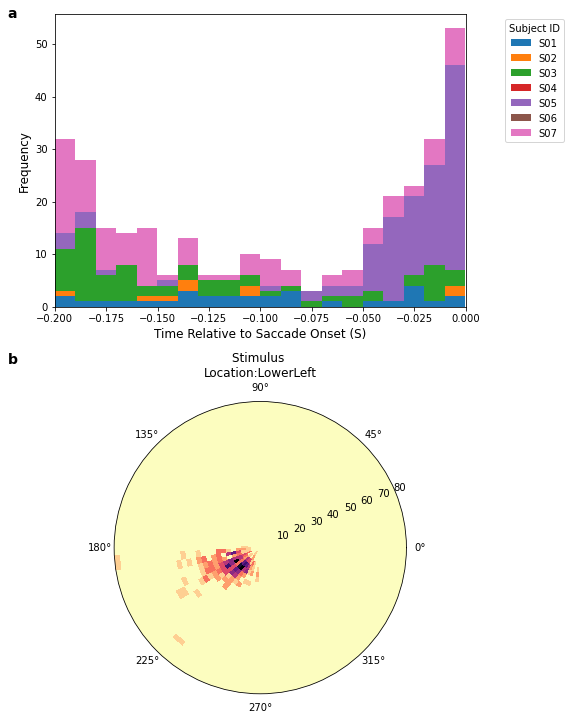

In [14]:
fig=plt.figure(figsize=(8,10))
fig.add_subplot(2,1,2,projection='polar')
# two input arrays
data=sacc200msOnsetDF
arr=np.radians(data['DirectionPolar'])
radius=data['VectorAmp']*60
N = 50

# We set bins based on stimulus location/pad accordingly
# create theta for 24 hours
theta = np.linspace(np.pi, (3*np.pi)/2, N, endpoint=False)
# define binning
rbins = np.linspace(0,radius.max(), 30)
abins = np.linspace(0,2*np.pi, 60)
#calculate histogram
hist, _, _ = np.histogram2d(arr, radius, bins=(abins, rbins))
A, R = np.meshgrid(abins, rbins)
pc = plt.pcolormesh(A, R, hist.T, cmap="magma_r")

#Column title
plt.title("Stimulus \nLocation:%s"%('LowerLeft'))
fig.add_subplot(2,1,1)
df=sacc200msOnsetDF
plt.hist([df.query("subj_id_x=='S01'")['relStimTime'],df.query("subj_id_x=='S02'")['relStimTime'],df.query("subj_id_x=='S03'")['relStimTime'],df.query("subj_id_x=='S04'")['relStimTime'],df.query("subj_id_x=='S05'")['relStimTime'],df.query("subj_id_x=='S06'")['relStimTime'],df.query("subj_id_x=='S07'")['relStimTime']],stacked=True,bins=20,label=['S01','S02','S03','S04','S05','S06','S07'])
plt.legend(title='Subject ID',bbox_to_anchor=(1.25,1))
plt.xlabel("Time Relative to Saccade Onset (S)",size=12)
plt.ylabel("Frequency",size=12)
plt.xlim(-0.2,0)
plt.tight_layout()
fig.text(0,0.98,r'$\bf{a}$',size=14)
fig.text(0,0.5,r'$\bf{b}$',size=14)

# plt.savefig("..\Plots\MicrosaccadeCharecteristcs.tiff",dpi=1200,bbox_tight='inches')

## Behavioral Performance

In [15]:
sacc200msOnsetDF.groupby(['subj_id_x','spacing'])['corr'].count()

subj_id_x  spacing   
S01        radial        17
           tangential    14
S02        radial         5
           tangential     4
S03        radial        35
           tangential    34
S05        radial        63
           tangential    50
S07        radial        61
           tangential    38
Name: corr, dtype: int64

In [16]:
# Statistical test for different in performance between groups 
trialcond_list=behavDataNoMicrosaccade.spacing.unique()
subs=behavDataNoMicrosaccade.subj_id.unique()
p_val_perf=[]
sub_list=[]
spacing_list=[]
for asub in subs:
    for trialCond in trialcond_list:
        data_nosacc=behavDataNoMicrosaccade.query("subj_id==@asub & spacing==@trialCond")['corr']
        data_sacc=sacc200msOnsetDF.query("subj_id_x==@asub & spacing==@trialCond")['corr']
        res_perf=perm_test(data_nosacc,data_sacc,1000,'mean',z_score=False)
        # append P val
        p_val_perf.append(res_perf['p_val'])
        # append other params
        sub_list.append(asub)
        spacing_list.append(trialCond)
p_val_df=pd.DataFrame(np.column_stack((sub_list,spacing_list,p_val_perf)),columns=['subj','spacing','p_val'])

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

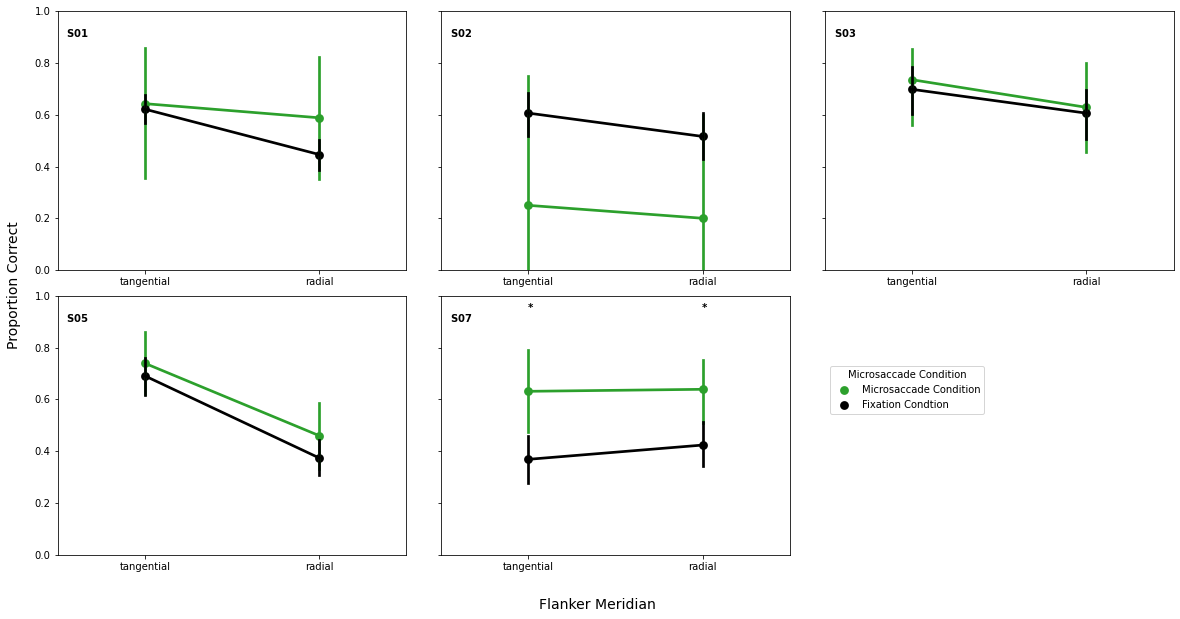

In [17]:
subs=sacc200msOnsetDF.subj_id_x.unique()
fig,ax=plt.subplots(nrows=2,ncols=3,sharey=True,figsize=(20,10))
idx=0
plot_lateMicrosaccade_trials=False
for row in ax:
    for col in row:
        if idx!=5:
            asub=subs[idx]
            df1=sacc200msOnsetDF.query("subj_id_x==@asub")
            df2=behavDataNoMicrosaccade.query("subj_id==@asub")
            #df3=saccMiddlems.query("subj_id_x==@asub")
            # Add another column that can be used for labels
            df1['trialCond']="Microsaccade Condition"
            df2['trialCond']='Fixation Condtion'
            #df3['trialCond']='Trials W late microsaccade'
            # We plot them as separate pointplots
            sns.pointplot(data=df1,x='spacing',y='corr',order=['tangential','radial'],hue='trialCond',palette=['C2'],ax=col)
            sns.pointplot(data=df2,x='spacing',y='corr',order=['tangential','radial'],hue='trialCond',palette=['k'],ax=col)
            if plot_lateMicrosaccade_trials==True:
                sns.pointplot(data=df3,x='spacing',y='corr',order=['tangential','radial'],hue='trialCond',palette=['C3'],ax=col)
            col.set_ylim(0,1)
            col.text(col.get_xlim()[0]+0.05,0.90,r"$\bf{%s}$"%asub)
            col.set_xlabel('')
            col.set_ylabel('')
            idx+=1
            if idx==5:
                col.legend(bbox_to_anchor=(1.1,0.75),title='Microsaccade Condition')
            else:
                col.get_legend().remove()

            # We also add asterisk mark for difference between conditions
            p_val_rad=float(p_val_df.query("subj==@asub & spacing=='radial'")['p_val'].values[0])
            p_val_tangential=float(p_val_df.query("subj==@asub & spacing=='tangential'")['p_val'].values[0])
            alpha_lvl=0.005
            if p_val_rad<alpha_lvl:
                col.text(0.99,0.95,r"$\bf{%s}$"%'*')
            if p_val_tangential<alpha_lvl:
                col.text(-0.01,0.95,r"$\bf{%s}$"%'*')
        else:
            fig.delaxes(col)
fig.text(0.09,0.5,"Proportion Correct",size=14,va='center',rotation=90)
fig.text(0.5,0.05,"Flanker Meridian",size=14,ha='center')
fig.subplots_adjust(wspace=0.1,hspace=0.1)

In [ ]:
## We subdivide saccade trials into ones with stimuli 0-150 ms and 150-300 ms before saccade onset  
sacc0to150ms=sacc300msOnsetDF.query("-0.150<relStimTime<0")
sacc150to300ms=sacc300msOnsetDF.query("-0.300<relStimTime<-0.150")
subs=sacc300msOnsetDF.subj_id_x.unique()
fig,ax=plt.subplots(nrows=2,ncols=3,sharey=True,figsize=(20,10))
idx=0
plot_lateMicrosaccade_trials=False
# We decide whether or not to show asterisk marks for significance
plot_significance=False
for row in ax:
    for col in row:
        if idx!=5:
            asub=subs[idx]
            df1=sacc0to150ms.query("subj_id_x==@asub")
            df2=sacc150to300ms.query("subj_id_x==@asub")
            df3=behavDataNoMicrosaccade.query("subj_id==@asub")
            df4=saccMiddlems.query("subj_id_x==@asub")
            # Add another column that can be used for labels
            df1['trialCond']="0-150ms before saccade onset"
            df2['trialCond']="150-300ms before saccade onset"
            df3['trialCond']='Fixation Condtion'
            df4['trialCond']='Trials W late microsaccade'
            # We plot them as separate pointplots
            sns.pointplot(data=df1,x='spacing',y='corr',order=['tangential','radial'],hue='trialCond',palette=['C2'],ax=col)
            sns.pointplot(data=df2,x='spacing',y='corr',order=['tangential','radial'],hue='trialCond',palette=['C1'],ax=col)
            sns.pointplot(data=df3,x='spacing',y='corr',order=['tangential','radial'],hue='trialCond',palette=['k'],ax=col)
            if plot_lateMicrosaccade_trials==True:
                sns.pointplot(data=df4,x='spacing',y='corr',order=['tangential','radial'],hue='trialCond',palette=['C3'],ax=col)
            col.set_ylim(0,1)
            col.text(col.get_xlim()[0]+0.05,0.90,r"$\bf{%s}$"%asub)
            col.set_xlabel('')
            col.set_ylabel('')
            idx+=1
            if idx==5:
                col.legend(bbox_to_anchor=(1.1,0.75),title='Microsaccade Condition')
            else:
                col.get_legend().remove()

            # We also add asterisk mark for difference between conditions
            if plot_significance==True:
                p_val_rad=float(p_val_df.query("subj==@asub & spacing=='radial'")['p_val'].values[0])
                p_val_tangential=float(p_val_df.query("subj==@asub & spacing=='tangential'")['p_val'].values[0])
                alpha_lvl=0.05
                if p_val_rad<alpha_lvl:
                    col.text(0.99,0.95,r"$\bf{%s}$"%'*')
                if p_val_tangential<alpha_lvl:
                    col.text(-0.01,0.95,r"$\bf{%s}$"%'*')
        else:
            fig.delaxes(col)
fig.text(0.09,0.5,"Proportion Correct",size=14,va='center',rotation=90)
fig.text(0.5,0.05,"Flanker Meridian",size=14,ha='center')
fig.subplots_adjust(wspace=0.1,hspace=0.1)

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


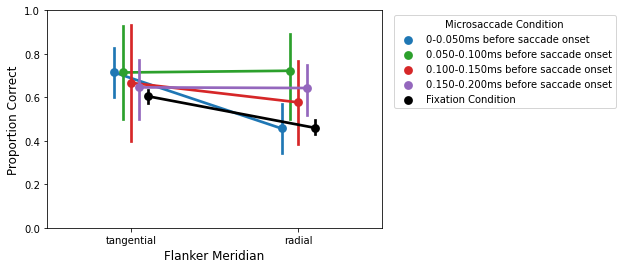

In [18]:
startTimeStamp=[0,-0.050,-0.100,-0.150]
endTimeStamp=[-0.050,-0.100,-0.150,-0.200]


num_steps=len(startTimeStamp)
saccDF_timeFiltered=[]
for i in range(num_steps):
    startTime=startTimeStamp[i]
    endTime=endTimeStamp[i]
    # We set color, marker & label based on condition
    if i==0:
        colorType='C0'
        markerLabel='%d-%.3fms before saccade onset'%(startTime,endTime*-1)
        markerType='x'
    elif i==1:
        colorType='C2'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='^'
    elif i==2:
        colorType='C3'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='o'
    elif i==3:
        colorType='C4'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='v'
    elif i==4:
        colorType='C5'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='+'
    # we filter saccade data
    saccDF_timeFiltered_temp=sacc200msOnsetDF.query("@endTime<relStimTime<@startTime")
    saccDF_timeFiltered_temp['trialCond']=markerLabel
    saccDF_timeFiltered.append(saccDF_timeFiltered_temp)
saccDF_timeFiltered=pd.concat(saccDF_timeFiltered)
# Create a similar DF for fixation condition
noSaccDF=behavDataNoMicrosaccade
noSaccDF['trialCond']='Fixation Condition'

#combined different DFs
timeFiltered_merged=[saccDF_timeFiltered,noSaccDF]
timeFiltered_merged=pd.concat(timeFiltered_merged)
    
    
# We plot them as separate pointplots
sns.pointplot(data=timeFiltered_merged,x='spacing',y='corr',order=['tangential','radial'],palette=['C0','C2','C3','C4','k'],hue='trialCond',dodge=0.2)

plt.legend(bbox_to_anchor=(1.02,1),title='Microsaccade Condition')
plt.ylim(0,1)
plt.xlabel("Flanker Meridian",size=12)
plt.ylabel("Proportion Correct",size=12)

plt.savefig("..\Plots\PerformanceVsFlankerMeridian_groupedbySaccadeCond.tiff",dpi=1200,bbox_inches='tight')

In [ ]:
saccDF_timeFiltered.trialCond.unique()

Text(0, 0.5, 'Z Scores')

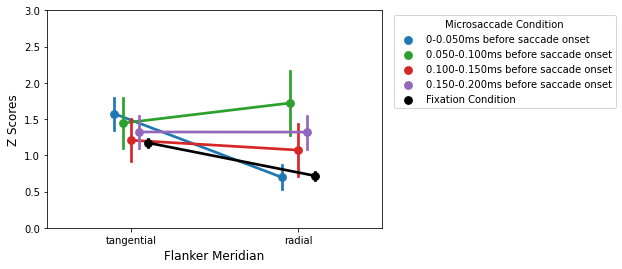

In [19]:
startTimeStamp=[0,-0.050,-0.100,-0.150]
endTimeStamp=[-0.050,-0.100,-0.150,-0.200]
spacings=['radial','tangential']

saccDF_timeFiltered=[]
noSaccDF=[]
num_steps=len(startTimeStamp)
for aspacing in spacings:
    for i in range(num_steps):
        startTime=startTimeStamp[i]
        endTime=endTimeStamp[i]
        # We set color, marker & label based on condition
        if i==0:
            colorType='C0'
            markerLabel='%d-%.3fms before saccade onset'%(startTime,endTime*-1)
            markerType='x'
        elif i==1:
            colorType='C2'
            markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
            markerType='^'
        elif i==2:
            colorType='C3'
            markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
            markerType='o'
        elif i==3:
            colorType='C4'
            markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
            markerType='v'
        elif i==4:
            colorType='C5'
            markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
            markerType='+'
        # we filter saccade data
        dataWsacc=sacc200msOnsetDF.query("@endTime<relStimTime<@startTime & spacing==@aspacing")['corr']
        propVals=bootstrap_corr_to_propCor(dataWsacc,num_boot=len(dataWsacc))
        zScores=bootstrap_corr_to_z(dataWsacc,num_boot=len(dataWsacc))
        saccDF_timeFiltered_temp=pd.DataFrame(np.column_stack((zScores,propVals)),columns=['zScores','propCorr'])
        saccDF_timeFiltered_temp['trialCond']=markerLabel
        saccDF_timeFiltered_temp['spacing']=aspacing
        saccDF_timeFiltered.append(saccDF_timeFiltered_temp)

    # Create a similar DF for fixation condition
    dataWOsacc=behavDataNoMicrosaccade.query("spacing==@aspacing")['corr']
    propVals=bootstrap_corr_to_propCor(dataWOsacc,num_boot=len(dataWOsacc))
    zScores=bootstrap_corr_to_z(dataWOsacc,num_boot=len(dataWOsacc))
    noSaccDF_temp=pd.DataFrame(np.column_stack((zScores,propVals)),columns=['zScores','propCorr'])
    noSaccDF_temp['trialCond']='Fixation Condition'
    noSaccDF_temp['spacing']=aspacing
    noSaccDF.append(noSaccDF_temp)

saccDF_timeFiltered=pd.concat(saccDF_timeFiltered)
noSaccDF=pd.concat(noSaccDF)

#combined different DFs
timeFilteredZScores_merged=[saccDF_timeFiltered,noSaccDF]
timeFilteredZScores_merged=pd.concat(timeFilteredZScores_merged)
    
    
# We plot them as separate pointplots
sns.pointplot(data=timeFilteredZScores_merged,x='spacing',y='zScores',ci='sd',order=['tangential','radial'],palette=['C0','C2','C3','C4','k'],hue='trialCond',dodge=0.2)

plt.legend(bbox_to_anchor=(1.02,1),title='Microsaccade Condition')
plt.ylim(0,3)
plt.xlabel("Flanker Meridian",size=12)
plt.ylabel("Z Scores",size=12)

# plt.savefig("..\Plots\PerformanceVsFlankerMeridian_groupedbySaccadeCond.tiff",dpi=1200,bbox_inches='tight')

## Flip errors

In [ ]:
# we look for proportion of trials where response is 180 deg away from the correct one
# We first do it for saccade condition
saccDF=sacc300msOnsetDF.query("corr==0")
flipDF_saccade=[]
# Upward target 
tempFlipDF_up=saccDF.query("target=='u'")
tempFlipDF_up['flipError']=np.where((tempFlipDF_up['resp']=='d'),1,0)
# Upward target 
tempFlipDF_down=saccDF.query("target=='d'")
tempFlipDF_down['flipError']=np.where((tempFlipDF_down['resp']=='u'),1,0)
# Leftward target 
tempFlipDF_left=saccDF.query("target=='l'")
tempFlipDF_left['flipError']=np.where((tempFlipDF_left['resp']=='r'),1,0)
# Rightward target 
tempFlipDF_right=saccDF.query("target=='r'")
tempFlipDF_right['flipError']=np.where((tempFlipDF_right['resp']=='l'),1,0)
# concat arrays
flipDF_saccade=pd.concat([tempFlipDF_up,tempFlipDF_down,tempFlipDF_left,tempFlipDF_right])

# We then repeat this for no saccade condition
noSaccDF=behavDataNoMicrosaccade.query("corr==0")
flipDF_noSacc=[]
# Upward target 
tempFlipDF_up=noSaccDF.query("target=='u'")
tempFlipDF_up['flipError']=np.where((tempFlipDF_up['resp']=='d'),1,0)
# Upward target 
tempFlipDF_down=noSaccDF.query("target=='d'")
tempFlipDF_down['flipError']=np.where((tempFlipDF_down['resp']=='u'),1,0)
# Leftward target 
tempFlipDF_left=noSaccDF.query("target=='l'")
tempFlipDF_left['flipError']=np.where((tempFlipDF_left['resp']=='r'),1,0)
# Rightward target 
tempFlipDF_right=noSaccDF.query("target=='r'")
tempFlipDF_right['flipError']=np.where((tempFlipDF_right['resp']=='l'),1,0)
# concat arrays
flipDF_noSacc=pd.concat([tempFlipDF_up,tempFlipDF_down,tempFlipDF_left,tempFlipDF_right])

In [ ]:
sns.pointplot(data=flipDF_saccade,x='spacing',y='flipError',order=['tangential','radial'],color='C2')
sns.pointplot(data=flipDF_noSacc,x='spacing',y='flipError',order=['tangential','radial'],color='k')
plt.ylim(0,1)
plt.axhline(y=0.33,xmin=0,xmax=1,color='k',ls='--')
plt.xlabel("Spacing",size=12)
plt.ylabel("Flip Error",size=12)

## Learning effect

In [ ]:
# First we add session num as separation column
def row_to_code(df):
    filenameStr=df["filename"]
    return "%s"%(filenameStr[5:(filenameStr.find("_T0"))])
behavData['sessionNum']=(behavData.apply(row_to_code,1)).astype(int)


In [ ]:
g=sns.FacetGrid(data=behavData,col='subj_id',row='spacing')
g.map(sns.pointplot,'sessionNum','corr')

## Z Score measures

In [ ]:
###### subs=behavData.subj_id.unique()
trialcond_list=behavDataNoMicrosaccade.spacing.unique()
zScore_sacc=[]
zScore_sacc0to150=[]
zScore_sacc150to300=[]
zScore_late_sacc=[]
zScore_noSacc=[]
total_iter=len(trialcond_list) * 5
counter=1
for asub in subs:
    for trialCond in trialcond_list:
        print("%d/%d"%(counter,total_iter),end='\r')
        #No Saccade Trials
        data_nosacc=behavDataNoMicrosaccade.query("subj_id==@asub & spacing==@trialCond")['corr']
        propVals=bootstrap_corr_to_propCor(data_nosacc)
        zScores=bootstrap_corr_to_z(data_nosacc)
        tempDF_nosacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_nosacc['subj']=asub
        tempDF_nosacc['spacing']=trialCond
        zScore_noSacc.append(tempDF_nosacc)
        #Saccade Trials
        data_sacc=sacc300msOnsetDF.query("subj_id_x==@asub & spacing==@trialCond")['corr']
        propVals=bootstrap_corr_to_propCor(data_sacc)
        zScores=bootstrap_corr_to_z(data_sacc)
        tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_sacc['subj']=asub
        tempDF_sacc['spacing']=trialCond
        zScore_sacc.append(tempDF_sacc)
        # Trials with Late microsaccades
        data_sacc=saccMiddlems.query("subj_id_x==@asub & spacing==@trialCond")['corr']
        propVals=bootstrap_corr_to_propCor(data_sacc)
        zScores=bootstrap_corr_to_z(data_sacc)
        tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_sacc['subj']=asub
        tempDF_sacc['spacing']=trialCond
        zScore_late_sacc.append(tempDF_sacc)
        # Trials with msacc 0-150 ms after stimulus onset
        data_sacc=sacc0to150ms.query("subj_id_x==@asub & spacing==@trialCond")['corr']
        propVals=bootstrap_corr_to_propCor(data_sacc)
        zScores=bootstrap_corr_to_z(data_sacc)
        tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_sacc['subj']=asub
        tempDF_sacc['spacing']=trialCond
        zScore_sacc0to150.append(tempDF_sacc)
        # Trials with msacc 150-300 ms after stimulus onset
        data_sacc=sacc150to300ms.query("subj_id_x==@asub & spacing==@trialCond")['corr']
        propVals=bootstrap_corr_to_propCor(data_sacc)
        zScores=bootstrap_corr_to_z(data_sacc)
        tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_sacc['subj']=asub
        tempDF_sacc['spacing']=trialCond
        zScore_sacc150to300.append(tempDF_sacc)
        counter+=1
zScore_sacc=pd.concat(zScore_sacc)
zScore_noSacc=pd.concat(zScore_noSacc)
zScore_late_sacc=pd.concat(zScore_late_sacc)
zScore_sacc0to150=pd.concat(zScore_sacc0to150)
zScore_sacc150to300=pd.concat(zScore_sacc150to300)

In [ ]:
# Statistical test for different in performance between groups 
trialcond_list=behavDataNoMicrosaccade.spacing.unique()
subs=behavDataNoMicrosaccade.subj_id.unique()
p_val_perf=[]
sub_list=[]
spacing_list=[]
for asub in subs:
    for trialCond in trialcond_list:
        data_nosacc=behavDataNoMicrosaccade.query("subj_id==@asub & spacing==@trialCond")['corr']
        data_sacc=sacc300msOnsetDF.query("subj_id_x==@asub & spacing==@trialCond")['corr']
        res_perf=perm_test(data_nosacc,data_sacc,1000,'mean',z_score=True)
        # append P val
        p_val_perf.append(res_perf['p_val'])
        # append other params
        sub_list.append(asub)
        spacing_list.append(trialCond)
p_val_zScore_df=pd.DataFrame(np.column_stack((sub_list,spacing_list,p_val_perf)),columns=['subj','spacing','p_val'])

In [ ]:
subs=zScore_sacc.subj.unique()
fig,ax=plt.subplots(nrows=2,ncols=3,sharey=True,figsize=(20,10))
idx=0
plot_lateMicrosaccade_trials=True
for row in ax:
    for col in row:
        if idx!=5:
            asub=subs[idx]
            df1=zScore_sacc.query("subj==@asub")
            df2=zScore_noSacc.query("subj==@asub")
            df3=zScore_late_sacc.query("subj==@asub")
            # Add another column that can be used for labels
            df1['trialCond']="Microsaccade Condition"
            df2['trialCond']='Fixation Condtion'
            df3['trialCond']='Trials W late Microsaccades'
            # We plot them as separate pointplots
            sns.pointplot(data=df1,x='spacing',y='zScores',order=['tangential','radial'],hue='trialCond',palette=['C2'],ci='sd',ax=col)
            sns.pointplot(data=df2,x='spacing',y='zScores',order=['tangential','radial'],hue='trialCond',palette=['k'],ci='sd',ax=col)
            if plot_lateMicrosaccade_trials==True:
                sns.pointplot(data=df3,x='spacing',y='zScores',order=['tangential','radial'],hue='trialCond',palette=['C3'],ci='sd',ax=col)
            col.set_ylim(0,3.5)
            col.text(col.get_xlim()[0]+0.05,3.25,r"$\bf{%s}$"%asub)
            col.set_xlabel('')
            col.set_ylabel('')
            idx+=1
            if idx==5:
                col.legend(bbox_to_anchor=(1.6,0.75),title='Microsaccade Condition')
            else:
                col.get_legend().remove()
            # We also add asterisk mark for difference between conditions
            p_val_rad=float(p_val_zScore_df.query("subj==@asub & spacing=='radial'")['p_val'].values[0])
            p_val_tangential=float(p_val_zScore_df.query("subj==@asub & spacing=='tangential'")['p_val'].values[0])
            alpha_lvl=0.05
            if p_val_rad<alpha_lvl:
                col.text(0.99,3.25,r"$\bf{%s}$"%'*')
            if p_val_tangential<alpha_lvl:
                col.text(-0.01,3.25,r"$\bf{%s}$"%'*')
        else:
            fig.delaxes(col)
fig.text(0.09,0.5,"Z Scores",size=14,va='center',rotation=90)
fig.text(0.5,0.05,"Flanker Meridian",size=14,ha='center')
fig.subplots_adjust(wspace=0.1,hspace=0.1)

In [ ]:
# We plot the saccade data subdivided based on ones with stimulus very close (0-150ms) to saccade onset 
# and ones that are just early (150-300ms)
subs=zScore_sacc.subj.unique()
fig,ax=plt.subplots(nrows=2,ncols=3,sharey=True,figsize=(20,10))
idx=0
plot_lateMicrosaccade_trials=False
# We decide whether or not to show asterisk marks for significance
plot_significance=False
for row in ax:
    for col in row:
        if idx!=5:
            asub=subs[idx]
            df1=zScore_sacc0to150.query("subj==@asub")
            df2=zScore_sacc150to300.query("subj==@asub")
            df3=zScore_noSacc.query("subj==@asub")
            df4=zScore_late_sacc.query("subj==@asub")
            # Add another column that can be used for labels
            df1['trialCond']="0-150ms before saccade onset"
            df2['trialCond']="150-300ms before saccade onset"
            df3['trialCond']='Fixation Condtion'
            df4['trialCond']='Trials W late microsaccade'
            # We plot them as separate pointplots
            sns.pointplot(data=df1,x='spacing',y='zScores',order=['tangential','radial'],hue='trialCond',palette=['C2'],ci='sd',ax=col)
            sns.pointplot(data=df2,x='spacing',y='zScores',order=['tangential','radial'],hue='trialCond',palette=['C1'],ci='sd',ax=col)
            sns.pointplot(data=df3,x='spacing',y='zScores',order=['tangential','radial'],hue='trialCond',palette=['k'],ci='sd',ax=col)
            if plot_lateMicrosaccade_trials==True:
                sns.pointplot(data=df4,x='spacing',y='zScores',order=['tangential','radial'],hue='trialCond',palette=['C3'],ci='sd',ax=col)
            col.set_ylim(0,3.5)
            col.text(col.get_xlim()[0]+0.05,3.25,r"$\bf{%s}$"%asub)
            col.set_xlabel('')
            col.set_ylabel('')
            idx+=1
            if idx==5:
                col.legend(bbox_to_anchor=(1.6,0.75),title='Microsaccade Condition')
            else:
                col.get_legend().remove()
            # We also add asterisk mark for difference between conditions
            if plot_significance==True:
                p_val_rad=float(p_val_zScore_df.query("subj==@asub & spacing=='radial'")['p_val'].values[0])
                p_val_tangential=float(p_val_zScore_df.query("subj==@asub & spacing=='tangential'")['p_val'].values[0])
                alpha_lvl=0.05
                if p_val_rad<alpha_lvl:
                    col.text(0.99,3.25,r"$\bf{%s}$"%'*')
                if p_val_tangential<alpha_lvl:
                    col.text(-0.01,3.25,r"$\bf{%s}$"%'*')
        else:
            fig.delaxes(col)
fig.text(0.09,0.5,"Z Scores",size=14,va='center',rotation=90)
fig.text(0.5,0.05,"Flanker Meridian",size=14,ha='center')
fig.subplots_adjust(wspace=0.1,hspace=0.1)

In [ ]:
###### subs=behavData.subj_id.unique()
trialcond_list=behavDataNoMicrosaccade.spacing.unique()
zScore_sacc0to150_combined=[]
zScore_sacc150to300_combined=[]
zScore_noSacc_combined=[]
total_iter=len(trialcond_list)
counter=1
for trialCond in trialcond_list:
    print("%d/%d"%(counter,total_iter),end='\r')
    #No Saccade Trials
    data_nosacc=behavDataNoMicrosaccade.query("spacing==@trialCond")['corr']
    propVals=bootstrap_corr_to_propCor(data_nosacc)
    zScores=bootstrap_corr_to_z(data_nosacc)
    tempDF_nosacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
    tempDF_nosacc['spacing']=trialCond
    zScore_noSacc_combined.append(tempDF_nosacc)
    # Trials with msacc 0-150 ms after stimulus onset
    data_sacc=sacc0to150ms.query("spacing==@trialCond")['corr']
    propVals=bootstrap_corr_to_propCor(data_sacc)
    zScores=bootstrap_corr_to_z(data_sacc)
    tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
    tempDF_sacc['spacing']=trialCond
    zScore_sacc0to150_combined.append(tempDF_sacc)
    # Trials with msacc 150-300 ms after stimulus onset
    data_sacc=sacc150to300ms.query(" spacing==@trialCond")['corr']
    propVals=bootstrap_corr_to_propCor(data_sacc)
    zScores=bootstrap_corr_to_z(data_sacc)
    tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
    tempDF_sacc['spacing']=trialCond
    zScore_sacc150to300_combined.append(tempDF_sacc)
    counter+=1
zScore_noSacc_combined=pd.concat(zScore_noSacc_combined)
zScore_sacc0to150_combined=pd.concat(zScore_sacc0to150_combined)
zScore_sacc150to300_combined=pd.concat(zScore_sacc150to300_combined)

In [ ]:
df1=zScore_sacc0to150_combined
df2=zScore_sacc150to300_combined
df3=zScore_noSacc_combined
# Add another column that can be used for labels
df1['trialCond']="0-150ms before saccade onset"
df2['trialCond']="150-300ms before saccade onset"
df3['trialCond']='Fixation Condtion'
df4['trialCond']='Trials W late microsaccade'
# We plot them as separate pointplots
sns.pointplot(data=df1,x='spacing',y='zScores',order=['tangential','radial'],hue='trialCond',palette=['C2'],ci='sd')
sns.pointplot(data=df2,x='spacing',y='zScores',order=['tangential','radial'],hue='trialCond',palette=['C1'],ci='sd')
sns.pointplot(data=df3,x='spacing',y='zScores',order=['tangential','radial'],hue='trialCond',palette=['k'],ci='sd')
plt.legend(bbox_to_anchor=(1.02,1),title='Microsaccade Condition')
plt.ylim(0,3.5)
plt.xlabel("Flanker Meridian",size=12)
plt.ylabel("Z Scores",size=12)

## Binned performance data

In [ ]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.050 #seconds
binSize=0.200

startPt=-0.250
endPt=0.050
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=sacc300msOnsetDF.subj_id_x.unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataPerf_sacc=[]
BinDataPerf_nosacc=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=sacc300msOnsetDF.query("@start<relStimTime<@end & subj_id_x==@asub").drop_duplicates(subset=['code'])
        perfDF['binPt']=abin
        BinDataPerf_sacc.append(perfDF)
        counter+=1
    #Trials W/o microsaccades 
    datanoSacc=behavDataNoMicrosaccade.query("subj_id==@asub")
    BinDataPerf_nosacc.append(datanoSacc)
                    
BinDataPerf_sacc=pd.concat(BinDataPerf_sacc)
BinDataPerf_nosacc=pd.concat(BinDataPerf_nosacc)

In [ ]:
fig,axs=plt.subplots(nrows=5,ncols=2,sharey=True,sharex=True,figsize=(15,15))
spacings= ['radial','tangential']
subs=BinDataPerf_sacc.subj_id_x.unique()

rowCounter=0
for row in axs:
    asub=subs[rowCounter]
    colCounter=0
    for col in row:
        aspacing=spacings[colCounter]
        #Microsaccade Condition
        df2_mean=BinDataPerf_sacc.query("spacing==@aspacing & subj_id_x==@asub").groupby(['binPt'])['corr'].mean().reset_index()
        # Compute CI
        df2_std=BinDataPerf_sacc.query("spacing==@aspacing & subj_id_x==@asub").groupby(['binPt'])['corr'].std().reset_index()
        df2_count=BinDataPerf_sacc.query("spacing==@aspacing & subj_id_x==@asub").groupby(['binPt'])['corr'].count().reset_index()
        x2=df2_std['binPt']
        ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
        col.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2',marker='.')
        #col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
        col.errorbar(df2_mean['binPt'],df2_mean['corr'],yerr=ci2,color='C2',ls = 'none',capsize = 5)

        #No saccade condition
        df3_mean=BinDataPerf_nosacc.query("spacing==@aspacing & subj_id==@asub")['corr'].mean()
        # Compute CI
        df3_std=BinDataPerf_nosacc.query("spacing==@aspacing & subj_id==@asub")['corr'].std()
        df3_count=BinDataPerf_nosacc.query("spacing==@aspacing & subj_id==@asub")['corr'].count()
        ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
        xvalues=np.linspace(startPt,0,5)
        col.hlines(xmin=startPt,xmax=0,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
        col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)
        # Add text to indicate condition
        if colCounter==3:
            col.text(col.get_xlim()[1]+0.0125,col.get_ylim()[1]-0.50,'Subj:%s'%(asub))
        if asub=='S01':
            if aspacing!=100:
                col.set_title("Flanker spacing:%s"%(aspacing))
            else:
                col.set_title("Flanker spacing: ∞")
        # Tweak axis for each plot
        col.set_xlim(startPt-0.010,0.010)
        col.set_ylim(0,1)
        colCounter+=1

    rowCounter+=1
fig.text(0.09,0.5,'Proportion Correct',size=16,va='center',rotation=90)
fig.text(0.5,0.07,'Time relative to saccade onset (s)',size=16,ha='center')

fig.subplots_adjust(hspace=0.2,wspace=0.1)

#plt.savefig("..\Plots\PerformanceVTime_bySpacing&Ecc.pdf",dpi=1200,bbox_tight='inches')

In [7]:
sacc_df=sacc600msOnsetDFWpostSaccade
# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.025 #seconds
binSize=0.130

startPt=-0.500
endPt=0.150
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=sacc_df.subj_id_x.unique()
spacings=sacc_df.spacing.unique()
numelements=len(subs)*len(bins)* len(spacings)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataPerf_sacc_combined=[]
BinDataPerf_nosacc_combined=[]
for asub in subs:
    for aspacing in spacings:
        for abin in bins:
            start=abin-binWidth
            end=abin+binWidth
            # Trials with microsaccades present
            print('%d/%d'%(counter,numelements),end='\r')
            perfDF=sacc_df.query("@start<relStimTime<@end & subj_id_x==@asub & spacing==@aspacing").drop_duplicates(subset=['code'])
            perfDF['binPt']=abin
            BinDataPerf_sacc_combined.append(perfDF)
            counter+=1
        #Trials W/o microsaccades 
        datanoSacc=behavDataNoMicrosaccade.query("subj_id==@asub & spacing==@aspacing")
        BinDataPerf_nosacc_combined.append(datanoSacc)
                    
BinDataPerf_sacc_combined=pd.concat(BinDataPerf_sacc_combined,ignore_index=True)
BinDataPerf_nosacc_combined=pd.concat(BinDataPerf_nosacc_combined,ignore_index=True)

In [8]:
# Common permutation test for all conditions
# We run permutation test for each time point/bin step 
bins=BinDataPerf_sacc_combined.binPt.unique()
spacings=BinDataPerf_sacc_combined.spacing.unique()
binPtList=[]
spacingList=[]
p_vals_perf=[]
idx=0
# loop through each bin
for abin in bins:
    for aspacing in spacings:
        group1_perf=np.array(BinDataPerf_sacc_combined.query("binPt==@abin & spacing==@aspacing & corr<2")['corr'])
        group2_perf=np.array(BinDataPerf_nosacc_combined.query("spacing==@aspacing & corr<2")['corr'])
        res_perf=perm_test(group1_perf,group2_perf,10000,'mean',z_score=False)
        # append P val
        p_vals_perf.append(res_perf['p_val'])
        binPtList.append(abin)
        spacingList.append(aspacing)
p_val_df=pd.DataFrame(np.column_stack((binPtList,spacingList,p_vals_perf)),columns=['binPt','spacing','p_val_perf'])
p_val_df['binPt']=p_val_df['binPt'].astype(float)
p_val_df['p_val_perf']=p_val_df['p_val_perf'].astype(float)

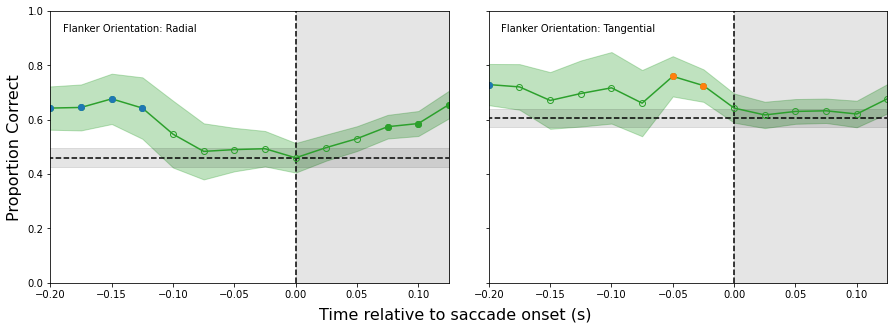

In [17]:
from matplotlib.lines import lineStyles


fig,axs=plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(15,5))
spacings= ['radial','tangential']
subs=BinDataPerf_sacc_combined.subj_id_x.unique()
# We can either have a line plot with error bands or point plot with error bars
# 1. lineplot
# 2. pointplot
plotKind='linePlot'

colCounter=0
for col in axs:    
    aspacing=spacings[colCounter]
    #Microsaccade Condition
    subs_list=['S01','S02','S03','S04','S05','S06','S07']
    query_string="spacing==@aspacing & subj_id_x==@subs_list"
    df2_mean=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].mean().reset_index()
    # Compute CI
    df2_std=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].std().reset_index()
    df2_count=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].count().reset_index()
    x2=df2_std['binPt']
    ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr'])
    binVals=df2_mean['binPt']
    perfVals=df2_mean['corr'] 
    col.plot(binVals,perfVals,color='C2',marker='o',linestyle='-',markerfacecolor='none',label='Microsaccade Trials')
    for i in range(len(binVals)):
        binValue=binVals[i]
        a_pval=p_val_df.query("binPt==@binValue & spacing==@aspacing")['p_val_perf'].values[0]
        alpha_lvl=0.005
        if a_pval<alpha_lvl:
            if binVals[i]<-0.100:
                colorType='C0'
            elif -0.100<binVals[i]<0:
                colorType='C1'
            else:
                colorType='C2'
            col.plot(binVals[i],perfVals[i],marker='o',color=colorType)
    if plotKind=='linePlot':
        col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.3)
    elif plotKind=='pointPlot':
        col.errorbar(df2_mean['binPt'],df2_mean['corr'],yerr=ci2,color='C2',ls = 'none',capsize = 5)

    #No saccade condition
    query_string="spacing==@aspacing & subj_id==@subs_list"
    df3_mean=BinDataPerf_nosacc_combined.query(query_string)['corr'].mean()
    # Compute CI
    df3_std=BinDataPerf_nosacc_combined.query(query_string)['corr'].std()
    df3_count=BinDataPerf_nosacc_combined.query(query_string)['corr'].count()
    ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
    xvalues=np.linspace(startPt,endPt,5)
    col.hlines(xmin=startPt,xmax=endPt,y=df3_mean,label='Valid Fixation Trials',color='k',linestyle='--')
    col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)
    xmin_val=-0.200
    col.set_xlim(xmin_val,endPt-stepSize)
    col.set_ylim(0,1)
    if colCounter==3:
        col.legend(loc='lower right')
    if colCounter==0:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.075,"Flanker Orientation: Radial")
    else:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.075,"Flanker Orientation: Tangential")
    # Add vertical line for saccade onset & shaded region following saccade onset
    col.fill_betweenx(y=[0,1],x1=0,x2=endPt-stepSize,color=[0,0,0],alpha=0.1) 
    col.vlines(0,ymin=0,ymax=1,color='k',ls='--')
    colCounter+=1
        
fig.subplots_adjust(hspace=0.2,wspace=0.1)
fig.text(0.085,0.5,'Proportion Correct',size=16,va='center',rotation=90)
fig.text(0.5,0.025,'Time relative to saccade onset (s)',size=16,ha='center')

plt.savefig("..\Plots\PerformanceVTime_bySpacing_1by2.tiff",dpi=1200,bbox_inches='tight')

In [12]:
# Microsaccade metrics binned with respect to stimulus onset
sacc_df=sacc600msOnsetDFWpostSaccade
# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.025 #seconds
binSize=0.130

startPt=-0.500
endPt=0.150
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=sacc_df.subj_id_x.unique()
spacings=sacc_df.spacing.unique()
numelements=len(subs)*len(bins)*len(spacings)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataZScore_sacc_combined=[]
BinDataZScore_nosacc_combined=[]
for aspacing in spacings:
    for abin in bins:
        print("%d/%d"%(counter,numelements),end='\r')
        start=abin-binWidth
        end=abin+binWidth
        #Saccade Trials
        data_sacc=sacc_df.query("@start<relStimTime<@end & spacing==@aspacing")['corr']
        propVals=bootstrap_corr_to_propCor(data_sacc,num_boot=len(data_sacc))
        zScores=bootstrap_corr_to_z(data_sacc,num_boot=len(data_sacc))
        tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_sacc['spacing']=aspacing
        tempDF_sacc['binPt']=float(abin)
        BinDataZScore_sacc_combined.append(tempDF_sacc)
        counter+=1
    #No Saccade Trials
    data_nosacc=behavDataNoMicrosaccade.query("spacing==@aspacing")['corr']
    propVals=bootstrap_corr_to_propCor(data_nosacc,num_boot=len(data_nosacc))
    zScores=bootstrap_corr_to_z(data_nosacc,num_boot=len(data_nosacc))
    tempDF_nosacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
    tempDF_nosacc['spacing']=aspacing
    BinDataZScore_nosacc_combined.append(tempDF_nosacc)
BinDataZScore_sacc_combined=pd.concat(BinDataZScore_sacc_combined)
BinDataZScore_nosacc_combined=pd.concat(BinDataZScore_nosacc_combined)

In [39]:
# Common permutation test for all conditions
# We run permutation test for each time point/bin step 
bins=BinDataZScore_sacc_combined.binPt.unique()
spacings=BinDataZScore_nosacc_combined.spacing.unique()
binPtList=[]
spacingList=[]
p_vals_perf=[]
p_vals_zScore=[]
idx=0
# loop through each bin
for abin in bins:
    for aspacing in spacings:
        # Run permutation for prop corr
        group1_perf=np.array(BinDataPerf_sacc_combined.query("binPt==@abin & spacing==@aspacing")['corr'])
        group2_perf=np.array(BinDataPerf_nosacc_combined.query("spacing==@aspacing")['corr'])
        res_perf=perm_test(group1_perf,group2_perf,10000,'mean',z_score=False)
        # Run permutation for z scores
        group1_zScore=np.array(BinDataPerf_sacc_combined.query("binPt==@abin & spacing==@aspacing")['corr'])
        group2_zScore=np.array(BinDataPerf_nosacc_combined.query("spacing==@aspacing")['corr'])
        res_zScore=perm_test(group1_perf,group2_perf,10000,'mean',z_score=True)
        # append P val
        p_vals_perf.append(res_perf['p_val'])
        p_vals_zScore.append(res_zScore['p_val'])
        binPtList.append(abin)
        spacingList.append(aspacing)
p_val_zScore_df=pd.DataFrame(np.column_stack((binPtList,spacingList,p_vals_perf,p_vals_zScore)),columns=['binPt','spacing','p_val_perf','p_val_zscore'])
p_val_zScore_df['binPt']=p_val_zScore_df['binPt'].astype(float)
p_val_zScore_df['p_val_perf']=p_val_zScore_df['p_val_perf'].astype(float)
p_val_zScore_df['p_val_zscore']=p_val_zScore_df['p_val_zscore'].astype(float)

Text(0.5, 0.025, 'Time relative to saccade onset (s)')

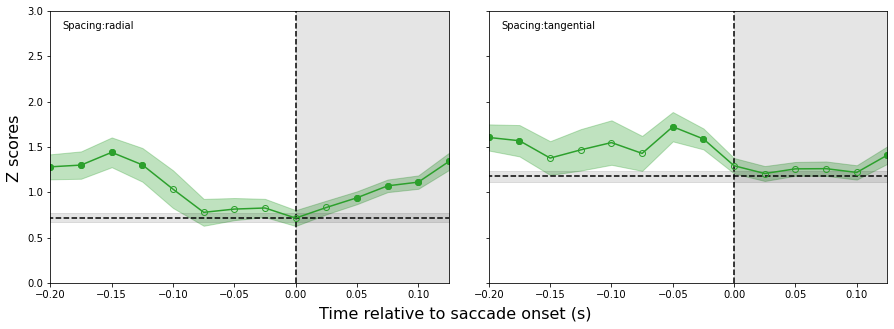

In [25]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(15,5))
spacings= ['radial','tangential']
#subs=BinDataZScore_sacc_combined.subj.unique()
dependentVar='zScores'
# if dependentVar=='propCorr':
#     p_valDF=p_val_df
# else:
#     p_valDF=p_val_zScore_df
# We can either have a line plot with error bands or point plot with error bars
# 1. lineplot
# 2. pointplot
plotKind='linePlot'

#we can also set CI parameter
#1. ci / 2. sd
error_bar_type='sd'

colCounter=0
for col in axs:    
    aspacing=spacings[colCounter]
    #Microsaccade Condition
    subs_list=['S01','S02','S03','S04','S05','S06','S07']
    query_string="spacing==@aspacing"# & subj==@subs_list"
    df2_mean=BinDataZScore_sacc_combined.query(query_string).groupby(['binPt'])[dependentVar].mean().reset_index()
    # Compute CI
    df2_std=BinDataZScore_sacc_combined.query(query_string).groupby(['binPt'])[dependentVar].std().reset_index()
    df2_count=BinDataZScore_sacc_combined.query(query_string).groupby(['binPt'])[dependentVar].count().reset_index()
    x2=df2_std['binPt']
    ci2=1.96 * (df2_std[dependentVar])/np.sqrt(df2_count[dependentVar]) 
    binVals=df2_mean['binPt']
    perfVals=df2_mean[dependentVar]
    col.plot(binVals,perfVals,color='C2',marker='o',linestyle='-',markerfacecolor='none',label='Microsaccade Trials')
    for i in range(len(binVals)):
        binValue=binVals[i]
        if dependentVar=='propCorr':
            a_pval=p_val_zScore_df.query("binPt==@binValue & spacing==@aspacing")['p_val_perf'].values[0]
            alpha_lvl=0.001
        elif dependentVar=='zScores':
            a_pval=p_val_zScore_df.query("binPt==@binValue & spacing==@aspacing")['p_val_zscore'].values[0]
            alpha_lvl=0.05
        if a_pval<alpha_lvl:
            col.plot(binVals[i],perfVals[i],marker='o',color='C2')
    if plotKind=='linePlot':
        if error_bar_type=='ci':
            col.fill_between(x2,(df2_mean[dependentVar]+ci2),(df2_mean[dependentVar]-ci2),color='C2',alpha=0.3)
        elif error_bar_type=='sd':
            df2_std_vals=df2_std[dependentVar]
            col.fill_between(x2,(df2_mean[dependentVar]+df2_std_vals),(df2_mean[dependentVar]-df2_std_vals),color='C2',alpha=0.3)
    elif plotKind=='pointPlot':
        col.errorbar(df2_mean['binPt'],df2_mean[dependentVar],yerr=ci2,color='C2',ls = 'none',capsize = 5)

    #No saccade condition
    query_string="spacing==@aspacing"# & subj==@subs_list"
    df3_mean=BinDataZScore_nosacc_combined.query(query_string)[dependentVar].mean()
    # Compute CI
    df3_std=BinDataZScore_nosacc_combined.query(query_string)[dependentVar].std()
    df3_count=BinDataZScore_nosacc_combined.query(query_string)[dependentVar].count()
    ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
    xvalues=np.linspace(startPt,endPt,5)
    col.hlines(xmin=startPt,xmax=endPt,y=df3_mean,label='Valid Fixation Trials',color='k',linestyle='--')
    if error_bar_type=='ci':
        col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)
    elif error_bar_type=='sd':
        col.fill_between(xvalues,(df3_mean+df3_std),(df3_mean-df3_std),color='k',alpha=0.1)
    xmin_val=-0.200
    col.set_xlim(xmin_val,endPt-stepSize)
    if dependentVar=='zScores':
        col.set_ylim(0,3)
        text_offset=0.2
    else:
        col.set_ylim(0,1)
        text_offset=0.1
    # col.set_ylim(0,1)
    if colCounter==3:
        col.legend(loc='lower right')
    if aspacing!=100:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-text_offset,"Spacing:%s"%(aspacing))
    else:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-text_offset,"Spacing: ∞")
    # Add vertical line for saccade onset & shaded region following saccade onset
    col.fill_betweenx(y=[0,6],x1=0,x2=endPt-stepSize,color=[0,0,0],alpha=0.1) 
    col.vlines(0,ymin=0,ymax=6,color='k',ls='--')
    colCounter+=1
        
fig.subplots_adjust(hspace=0.2,wspace=0.1)
if dependentVar=='zScores':
    fig.text(0.085,0.5,'Z scores',size=16,va='center',rotation=90)
else:
    fig.text(0.085,0.5,'Proportion correct',size=16,va='center',rotation=90)
fig.text(0.5,0.025,'Time relative to saccade onset (s)',size=16,ha='center')

#plt.savefig("..\Plots\PerformanceVTime_bySpacing_1by4.svg",dpi=1200,bbox_inches='tight')

In [26]:
# Compute difference in Z Scores between groups
spacings=BinDataZScore_sacc_combined.spacing.unique()
bins=BinDataZScore_sacc_combined.binPt.unique()

# Create empty list for values
spacing_list=[]
sub_list=[]
bin_list=[]
diff_zScores=[]

for aspacing in spacings:
    noSaccDF=BinDataZScore_nosacc_combined.query("spacing==@aspacing")['zScores']
    for abin in bins:
        saccDF=BinDataZScore_sacc_combined.query("spacing==@aspacing and binPt==@abin")['zScores']
        for i in range(1000):
            new_df_sacc = saccDF.sample(n=len(saccDF),replace=True)
            new_df_nosacc=noSaccDF.sample(n=len(noSaccDF),replace=True)
            # get diff in z scores
            zscore_diff=np.mean(new_df_sacc)-np.mean(new_df_nosacc)
            # append to lists
            spacing_list.append(aspacing)
            bin_list.append(abin)
            diff_zScores.append(zscore_diff)
zScoreDiff_DF=pd.DataFrame(np.column_stack((spacing_list,bin_list,diff_zScores)),columns=['spacing','binPt','zScoreDiff'])
zScoreDiff_DF['zScoreDiff']=zScoreDiff_DF['zScoreDiff'].astype(float)
zScoreDiff_DF['binPt']=zScoreDiff_DF['binPt'].astype(float)


Text(0.5, 0.025, 'Time relative to saccade onset (s)')

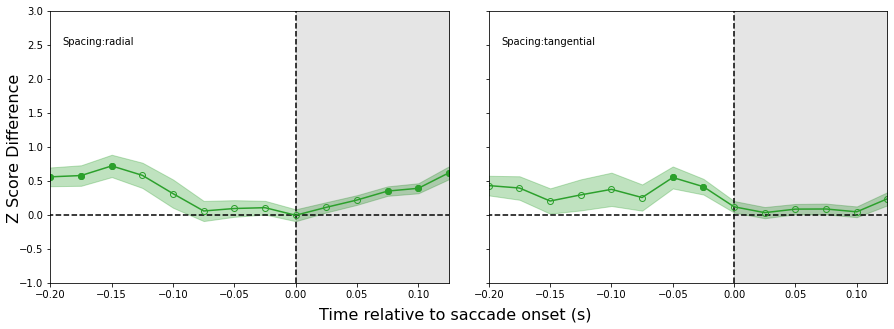

In [27]:
from matplotlib.lines import lineStyles

#we can also set CI parameter
#1. ci / 2. sd
error_bar_type='sd'

fig,axs=plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(15,5))
spacings= ['radial','tangential']
subs=BinDataPerf_sacc_combined.subj_id_x.unique()
# We can either have a line plot with error bands or point plot with error bars
# 1. lineplot
# 2. pointplot
plotKind='linePlot'
colCounter=0
for col in axs:    
    aspacing=spacings[colCounter]
    #Microsaccade Condition
    subs_list=['S01','S02','S03','S04','S05','S06','S07']
    query_string="spacing==@aspacing"# & subj==@subs_list"
    df2_mean=zScoreDiff_DF.query(query_string).groupby(['binPt'])['zScoreDiff'].mean().reset_index()
    # Compute CI
    df2_std=BinDataZScore_sacc_combined.query(query_string).groupby(['binPt'])['zScores'].std().reset_index()
    df2_count=BinDataZScore_sacc_combined.query(query_string).groupby(['binPt'])['zScores'].count().reset_index()
    x2=df2_std['binPt']
    ci2=1.96 * (df2_std['zScores'])/np.sqrt(df2_count['zScores']) 
    binVals=df2_mean['binPt']
    perfVals=df2_mean['zScoreDiff']
    col.plot(binVals,perfVals,color='C2',marker='o',linestyle='-',markerfacecolor='none',label='Microsaccade Trials')
    for i in range(len(binVals)):
        binValue=binVals[i]
        a_pval=p_val_zScore_df.query("binPt==@binValue & spacing==@aspacing")['p_val_zscore'].values[0]
        alpha_lvl=0.001
        if a_pval<alpha_lvl:
            col.plot(binVals[i],perfVals[i],marker='o',color='C2')
    if plotKind=='linePlot':
        if error_bar_type=='ci':
            col.fill_between(x2,(df2_mean['zScoreDiff']+ci2),(df2_mean['zScoreDiff']-ci2),color='C2',alpha=0.3)
        elif error_bar_type=='sd':
            df2_std_vals=df2_std['zScores']
            col.fill_between(x2,(df2_mean['zScoreDiff']+df2_std_vals),(df2_mean['zScoreDiff']-df2_std_vals),color='C2',alpha=0.3)
    elif plotKind=='pointPlot':
        col.errorbar(df2_mean['binPt'],df2_mean['zScoreDiff'],yerr=ci2,color='C2',ls = 'none',capsize = 5)

    ymax_val=3
    xmin_val=-0.200
    col.set_xlim(xmin_val,endPt-stepSize)
    col.set_ylim(-1,ymax_val)
    if colCounter==3:
        col.legend(loc='lower right')
    if aspacing!=100:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.5,"Spacing:%s"%(aspacing))
    else:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.5,"Spacing: ∞")
    # Add vertical line for saccade onset & shaded region following saccade onset
    col.fill_betweenx(y=[-1,ymax_val],x1=0,x2=endPt-stepSize,color=[0,0,0],alpha=0.1) 
    col.vlines(0,ymin=-1,ymax=ymax_val,color='k',ls='--')
    col.hlines(xmin=startPt,xmax=endPt-stepSize,y=0,color='k',ls='--')
    colCounter+=1
        
fig.subplots_adjust(hspace=0.2,wspace=0.1)
fig.text(0.085,0.5,'Z Score Difference',size=16,va='center',rotation=90)
fig.text(0.5,0.025,'Time relative to saccade onset (s)',size=16,ha='center')

In [ ]:
## We save the binned data frames
BinDataPerf_sacc_combined.to_csv("binDataPerf_sacc_combined.csv")
BinDataPerf_nosacc_combined.to_csv("binDataPerf_nosacc_combined.csv")

BinDataZScore_sacc_combined.to_csv("binDataZscore_sacc_combined.csv")
BinDataZScore_nosacc_combined.to_csv('binDataZscore_nosacc_combined.csv')

zScoreDiff_DF.to_csv("zScoreDiff.csv")

In [89]:
significantBins=p_val_df.query("p_val_perf<0.005 & -0.200<binPt<0")['binPt'].values
significantBins=np.unique(significantBins,axis=0)

saccDF_timeFiltered=[]
counter=0
for abin in significantBins:
    # We set color, marker & label based on condition
    if counter<=3:
        colorType='C0'
        markerType='x'
        markerLabel='%.3f to %.3f ms before saccade onset'%(-0.200,-0.125)
    elif counter>3:
        colorType='C2'
        markerType='^'
        markerLabel='%.3f to %.3f ms before saccade onset'%(-0.050,0.-0.025)

    # we filter saccade data
    
    saccDF_timeFiltered_temp=BinDataPerf_sacc_combined.query("binPt==@abin")
    saccDF_timeFiltered_temp['trialCond']=markerLabel
    saccDF_timeFiltered.append(saccDF_timeFiltered_temp)
    counter+=1
saccDF_timeFiltered=pd.concat(saccDF_timeFiltered)
# Create a similar DF for fixation condition
noSaccDF=BinDataPerf_nosacc_combined
noSaccDF['trialCond']='Fixation Condition'

#combined different DFs
timeFiltered_merged=[saccDF_timeFiltered,noSaccDF]
timeFiltered_merged=pd.concat(timeFiltered_merged)
    

# Common permutation test for all conditions
# We run permutation test for each time point/bin step 
num_conds=len(timeFiltered_merged.trialCond.unique())
trialCondList=[]
p_vals_perf=[]
for i in range(num_conds):
    cond=timeFiltered_merged.trialCond.unique()[i]
    group1_perf=timeFiltered_merged.query("spacing=='radial' & trialCond==@cond")['corr']
    group2_perf=timeFiltered_merged.query("spacing=='tangential' & trialCond==@cond")['corr']
    res_perf=perm_test(group1_perf,group2_perf,10000,'mean',z_score=False)
    # append P val
    p_vals_perf.append(res_perf['p_val'])
    trialCondList.append(cond)
p_val_pointplot_df=pd.DataFrame(np.column_stack((trialCondList,p_vals_perf)),columns=['trialCond','p_val_perf'])
p_val_pointplot_df['p_val_perf']=p_val_pointplot_df['p_val_perf'].astype(float)
p_val_pointplot_df

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


trialCond  p_val_perf
0  -0.200 to -0.125 ms before saccade onset      0.0444
1  -0.050 to -0.025 ms before saccade onset      0.0000
2                        Fixation Condition      0.0000

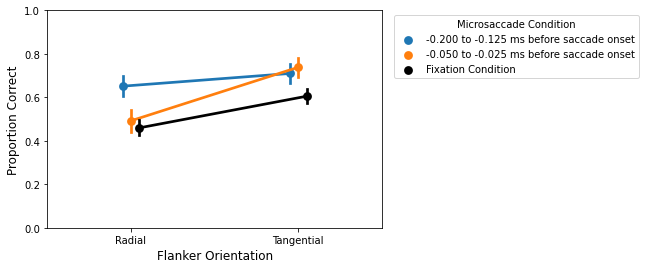

In [90]:
# We plot them as separate pointplots
fig, axs = plt.subplots()
sns.pointplot(data=timeFiltered_merged,x='spacing',y='corr',order=['radial','tangential'],ci=95,palette=['C0','C1','k'],hue='trialCond',dodge=0.1,label=['Radial','Tangential'],ax=axs)

axs.legend(bbox_to_anchor=(1.02,1),title='Microsaccade Condition')
axs.set_ylim(0,1)
axs.set_xlabel("Flanker Orientation",size=12)
axs.set_ylabel("Proportion Correct",size=12)
axs.set_xticklabels(['Radial','Tangential'])

plt.savefig("..\Plots\PerformanceVsFlankerMeridian_groupedbySaccadeCond.tiff",dpi=1200,bbox_inches='tight')

### Control Condition
Here we ran other spacings for the fixation condition to determine the shape of the crowding zone

In [15]:
# we do the same thing as earlier but for each subject individually and create a df with critical spacings
# First step is to get a function
# Have a function that pulls in the X & Y values from df, fits the data and get the Critical spacing
def fit_and_get_CS(df,x_lin):
    # First sort the x & y values from the DF
    x_all=df['spacing_value'].unique()
    y_all=df.groupby('spacing_value')['corr'].mean().values
    x_all.sort()
    y_all.sort()
    #optimize fit 
    p0 = [3.5, 2,0.05]
    w,_=opt.curve_fit(func_weibull,x_all,y_all,p0=p0,bounds=(0,[10, 10,1]),maxfev=10000)
    # model fit
    y_model=func_weibull(x_lin,*w)
    # Compute Critical Spacing (CS)
    CS=np.interp(0.75*np.max(y_model), y_model,x_lin)
    # Also add interpolated 50% of asymptotic level
    fifty_percent_interp=np.interp(0.50*np.max(y_model), y_model,x_lin)
    # return the paramters
    return w,y_model,CS,fifty_percent_interp
# we first create the empty arrays that will be filling inside the loop
y_model_rad_list=np.array([])
y_model_tang_list=np.array([])
x_lin_list=np.array([])
CS_rad_list=np.array([])
CS_tang_list=np.array([])
ecc_array=np.array([])
sub_list=np.array([])
# Get the fit parameters too
w1_lambda_list=np.array([])
w1_k_list=np.array([])
w1_lr_list=np.array([])
w2_lambda_list=np.array([])
w2_k_list=np.array([])
w2_lr_list=np.array([])
w_sub_list=np.array([])
# Get CS measures
cs_radlist=np.array([])
cs_tanglist=np.array([])
# Create an empty df and fill inside loop
subjs=behavDataControl['subj_id'].unique()

counter=1
for asub in subjs:
    dataRadial=behavDataControl.query("spacing=='radial' or spacing=='unflanked'")
    dataWTangential=behavDataControl.query("spacing=='tangential' or spacing=='unflanked'")

    # We use bootstrapping procedure for each getting the fit for each resampled data 
    for resample_idx in range(1000):
        print('%d/%d'%(counter,2000),end='\r')
        #1. Resample DF
        new_df_rad = dataRadial.sample(n=len(dataRadial),replace=True)
        new_df_tang=dataWTangential.sample(n=len(dataWTangential),replace=True)
        # Model
        unflanked_position=5
        x_lin=np.linspace(0,unflanked_position,50)
        w1,y_model_rad,CS_rad,fifty_percent_interp_rad = fit_and_get_CS(new_df_rad,x_lin)
        w2,y_model_tang,CS_tang,fifty_percent_interp_tabg=fit_and_get_CS(new_df_tang,x_lin)

        # Finally we save it to a DF
        y_model_rad_list=np.concatenate((y_model_rad_list,y_model_rad),axis=None)
        y_model_tang_list=np.concatenate((y_model_tang_list,y_model_tang),axis=None)
        x_lin_list=np.concatenate((x_lin_list,x_lin),axis=None)
        sub_list=np.concatenate((sub_list,np.repeat(asub,len(y_model_rad))))
        # we append subj id to fit params
        w1_lambda_list=np.concatenate((w1_lambda_list,w1[0]),axis=None)
        w1_k_list=np.concatenate((w1_k_list,w1[1]),axis=None)
        w1_lr_list=np.concatenate((w1_lr_list,w1[2]),axis=None)
        w2_lambda_list=np.concatenate((w2_lambda_list,w2[0]),axis=None)
        w2_k_list=np.concatenate((w2_k_list,w2[1]),axis=None)
        w2_lr_list=np.concatenate((w2_lr_list,w2[2]),axis=None)
        w_sub_list=np.concatenate((w_sub_list,asub),axis=None)
        cs_radlist=np.concatenate((cs_radlist,CS_rad),axis=None)
        cs_tanglist=np.concatenate((cs_tanglist,CS_tang),axis=None)
        counter+=1
#create individual df's and append together
# Model DF
y_model_df_rad=pd.DataFrame((np.column_stack((x_lin_list,y_model_rad_list,sub_list))),columns=['x_lin','y_model','subj'])
y_model_df_rad['Flanker Orientation']='Radial'
y_model_df_tang=pd.DataFrame((np.column_stack((x_lin_list,y_model_tang_list,sub_list))),columns=['x_lin','y_model','subj'])
y_model_df_tang['Flanker Orientation']='Tangential'
frames=[y_model_df_rad,y_model_df_tang]
y_model_df=pd.concat(frames)
y_model_df['x_lin']=y_model_df['x_lin'].astype('float')
y_model_df['y_model']=y_model_df['y_model'].astype('float')

# Create separate CS DF
cs_df_rad=pd.DataFrame((np.column_stack((cs_radlist,w_sub_list))),columns=['CS','subj'])
cs_df_rad['Flanker Orientation']='Radial'
cs_df_tang=pd.DataFrame((np.column_stack((cs_tanglist,w_sub_list))),columns=['CS','subj'])
cs_df_tang['Flanker Orientation']='Tangential'
frames=[cs_df_rad,cs_df_tang]
CS_df=pd.concat(frames)
CS_df['CS']=CS_df['CS'].astype(float)

(0.0, 1.0)

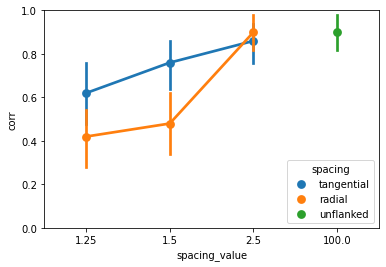

In [6]:
bootstrap_fit=True
subs=behavDataControl.subj_id.unique()
fig,ax=plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(20,10))
subCounter=0
for row in ax:
    for col in row:
        asub=subs[subCounter]
        # This plots the psychometric function in trials with and without microsaccades independently
        # Set whether or not to use bootstrap fit
        # First we declare the data/trials with congruent microsaccades
        datatang=behavDataControl.query("spacing=='radial' or spacing=='unflanked'") # to fix cases where the rel onset time is really big
        #get samples
        x_all = datatang['spacing'].unique()
        #     x_all.sort()
        y_all = datatang.groupby('spacing')['corr'].mean().values
        x_tang=x_all#[:-1]
        x_tang.sort()
        y_tang=y_all#[:-1]
        y_tang.sort()

        # second we declare the data/trials without microsaccades
        datatang=behavDataControl.query("spacing=='tangential' or spacing=='unflanked'")  # to fix cases where the rel onset time is really big
        #get samples
        x_all = datatang['spacing'].unique()
        #     x_all.sort()
        y_all = datatang.groupby('spacing')['corr'].mean().values
        x_nosacc=x_all#[:-1]
        x_nosacc.sort()
        y_nosacc=y_all#[:-1]
        y_nosacc.sort()


        # REGRESSION ------------------------------------------------------------------
        p0 = [3.5, 2,0.05] #weibull                                       # guessed params
        #     p0=[-1.5,-1,1] # exponential
        w1, _ = opt.curve_fit(func_weibull, x_sacc, y_sacc, p0=p0)
        w2, _ = opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
    #     print("Estimated Parameters:Saccade", w1)  
    #     print("Estimated Parameters:no saccade", w2)  

        unflanked_position=5
        # Model
        x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
        y_model_sacc = func_weibull(x_lin, *w1)
        y_model_nosacc= func_weibull(x_lin, *w2)

        #plot congruent microsaccade condition
    #     sns.pointplot(data=dataWsacc,x='spacing',y='corr',join=False,ax=col,palette=['C2'])
        col.plot(x_sacc[:-1], y_sacc[:-1],ls='',marker='v',color='C2',label='Valid Microsaccade Trials')
        col.plot(unflanked_position,y_sacc[-1], marker='v',color='C2')

        if bootstrap_fit==True:
            sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df.query("microsaccade_condition=='saccade' & subj==@asub"),ax=col)
        else:
            col.plot(x_lin,y_model_sacc,ls='--',color='C2')
        #plot no saccade condtion
    #     sns.pointplot(data=dataWOsacc,x='spacing',y='corr',join=False,ax=col,palette=['k'])
        col.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Valid Fixation Trials')
        col.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')

        if bootstrap_fit==True:
            sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df.query("microsaccade_condition=='no_saccade' & subj==@asub"),ax=col)
            col.set_xlabel('')
            col.set_ylabel('')
        else:
            col.plot(x_lin,y_model_nosacc,ls='--',color='k')
        #plot tweaks
        if subCounter==6:
            col.legend(title='Microsaccade condition',bbox_to_anchor=(1.8,0.6), prop={'size': 12})
        else:
            if bootstrap_fit==True:
                col.get_legend().remove()
        col.set_ylim(0,1)
        col.set_xlim(0.5,6)
        col.set_xscale('log')
        col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        col.set_xticks([1,2,3,unflanked_position])
        col.set_xticklabels(['1','2','3','∞'])